In [1]:
import dask.dataframe as dd

#Load the dataset with Dask
data = dd.read_csv('/home/olive0927/DFCI_projects/HDAC1_analysis/Deleteome_analysis/deleteome_all_mutants_ex_wt_var_controls_111024.txt', sep='\t', dtype=str)

data = data.loc[1:].reset_index(drop=True)
data.head()

,reporterId,systematicName,geneSymbol,swd1-del-matA vs. wt-matA,swd1-del-matA vs. wt-matA.1,swd1-del-matA vs. wt-matA.2,ptc1-del vs. wt,ptc1-del vs. wt.1,ptc1-del vs. wt.2,tlc1-del vs. wt,...,uba3-del vs. wt.2,wt-matA vs wt,wt-matA vs wt.1,wt-matA vs wt.2,wt-by4743 vs. wt,wt-by4743 vs. wt.1,wt-by4743 vs. wt.2,wt-ypd vs. wt,wt-ypd vs. wt.1,wt-ypd vs. wt.2
0,SCAB000001,Q0010,Q0010,0.0076834948,5.7383149,0.958054,-0.0023376161,5.6394251,0.983617,-0.054759384,...,0.977855,5.6418191,-0.017202417,0.265474,5.7688422,0.0083864892,0.91202,5.6007679,-0.02910071,0.616744
1,SCAB000002,Q0017,Q0017,-0.093275612,5.7430479,0.432495,-0.00078359617,5.6637426,0.993043,-0.084442387,...,0.979155,5.6518733,-0.011236069,0.417339,5.845863,0.010049357,0.897931,5.6021664,-0.01279994,0.83518
2,SCAB000003,Q0032,Q0032,-0.020262902,5.8495953,0.902186,0.020754644,5.7035622,0.854116,-0.011870142,...,0.973643,5.7529281,-0.012401174,0.568422,5.8659162,0.013855263,0.905891,5.6727664,-0.007499834,0.943031
3,SCAB000004,Q0045,COX1,-0.80578684,7.3644598,2.40595e-06,-0.29111708,5.8678774,0.0181674,0.082048528,...,0.91132,6.3654176,-0.010878436,0.605649,6.6100395,-0.21042431,0.00405308,5.9680521,-0.16079984,0.019957
4,SCAB000007,Q0060,AI3,0.02238912,8.5986755,0.946646,-2.0106226,6.5326525,6.73836e-19,0.20960309,...,0.870419,7.2484737,-0.079449058,0.0686784,7.8563925,0.1831117,0.332364,6.5062512,-0.89130026,0


In [2]:
import pandas as pd
data_pd = data.compute()

In [3]:
#Initialize dictionaries for storing up and downregulated genes per condition
condition_upregulated = {}
condition_downregulated = {}

In [4]:
#Iterate over columns to find gene-del conditions (ptc1-del vs wt & similar)
for col in data_pd.columns:
    if col.endswith("wt") and "-del" in col and "mat" not in col:
        m_col = col  # M-values directly from wt
        p_col = f"{col}.2"  # p-values from wt.2

        #Verify both M-value & p-value columns exist
        if m_col in data_pd.columns and p_col in data_pd.columns:
            
            #Convert to numeric, coercing any errors
            data_pd[m_col] = pd.to_numeric(data_pd[m_col], errors='coerce')
            data_pd[p_col] = pd.to_numeric(data_pd[p_col], errors='coerce')

            #Filter significant genes with p-value < 0.05
            significant_genes = data_pd.loc[data_pd[p_col] < 0.05].copy()  # Ensure we're working with a copy

            #Calculate Fold Change (FC) from M (log2FC), where FC = 2 ^ M
            significant_genes['Fold Change'] = 2 ** significant_genes[m_col]

            #Store up & downregulated genes with correct FC cutoffs (FC > 2 for up, FC < 0.5 for down)
            up_genes = significant_genes.loc[significant_genes['Fold Change'] > 2, 'systematicName'].tolist()  #FC > 2
            down_genes = significant_genes.loc[significant_genes['Fold Change'] < 0.5, 'systematicName'].tolist()  #FC < 0.5

            #Add to dictionaries
            condition_upregulated[m_col] = up_genes
            condition_downregulated[m_col] = down_genes

            #Print summary only if we've > 100 DGEs (either up or downregulated)
            if len(up_genes) > 100 or len(down_genes) > 100:
                print(f"Condition: {m_col}")
                if len(up_genes) > 100:
                    print(f"  Upregulated Genes (FC > 2): {len(up_genes)}")
                if len(down_genes) > 100:
                    print(f"  Downregulated Genes (FC < 0.5): {len(down_genes)}\n")
        else:
            print(f"Skipping {col}: Either {m_col} or {p_col} not found.")

#Printing the results for rpd3 & sin3 conditions as you specified
print("RPD3-del Condition:")
print(f"  Upregulated Genes: {len(condition_upregulated.get('rpd3-del vs. wt', []))}")
print(f"  Downregulated Genes: {len(condition_downregulated.get('rpd3-del vs. wt', []))}")

print("\nSin3-del Condition:")
print(f"  Upregulated Genes: {len(condition_upregulated.get('sin3-del vs. wt', []))}")
print(f"  Downregulated Genes: {len(condition_downregulated.get('sin3-del vs. wt', []))}")

#Fully reproduced with /DFCI_projects/HDAC1_analysis/scRNAseq_analysis_Nature/deleteome_analysis/Deleteome_analysis_FC2_pval0.05_28012025.ipynb 

Condition: ptc1-del vs. wt
  Upregulated Genes (FC > 2): 151
Condition: tlc1-del vs. wt
  Upregulated Genes (FC > 2): 293
Condition: swa2-del vs. wt
  Upregulated Genes (FC > 2): 210
Condition: sfp1-del vs. wt
  Upregulated Genes (FC > 2): 145
  Downregulated Genes (FC < 0.5): 110

Condition: thp1-del vs. wt
  Upregulated Genes (FC > 2): 124
Condition: nam7-del vs. wt
  Upregulated Genes (FC > 2): 241
Condition: ino4-del vs. wt
  Upregulated Genes (FC > 2): 158
Condition: caf17-del vs. wt
  Upregulated Genes (FC > 2): 117
Condition: nmd2-del vs. wt
  Upregulated Genes (FC > 2): 246
Condition: kem1-del vs. wt
  Upregulated Genes (FC > 2): 436
  Downregulated Genes (FC < 0.5): 123

Condition: grr1-del vs. wt
  Upregulated Genes (FC > 2): 314
Condition: opi1-del vs. wt
  Upregulated Genes (FC > 2): 123
Condition: rtt109-del vs. wt
  Upregulated Genes (FC > 2): 121
Condition: vps15-del vs. wt
  Upregulated Genes (FC > 2): 189
Condition: not4-del vs. wt
  Upregulated Genes (FC > 2): 295
  D

In [6]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

#Function to plot Venn diagram with additional checks:
def plot_venn(set1, set2, label1, label2, title):
    set1 = set(map(str, set1))
    set2 = set(map(str, set2))
    
    #Print the sets & their lengths for diagnostics
    print(f"Plotting Venn Diagram for {title}:")
    print(f"  {label1} (size={len(set1)}): {list(set1)[:10]}")
    print(f"  {label2} (size={len(set2)}): {list(set2)[:10]}")

    #Check if both sets are non-empty before plotting
    if len(set1) > 0 and len(set2) > 0:
        plt.figure(figsize=(6, 6))
        venn = venn2([set1, set2], (label1, label2))
        
        for idx, label in enumerate(('10', '01', '11')):
            if venn.get_label_by_id(label):
                venn.get_label_by_id(label).set_fontsize(12)
        
        plt.title(title, fontsize=14)
        plt.show()
    else:
        print(f"Skipping {title} due to empty set(s): {label1} size={len(set1)}, {label2} size={len(set2)}")


In [7]:
#Latest RNA-seq results (yeast): 

#Load Excel with each sheet as a condition
excel_path = "DESeq2_DEGs_yeast_09042025.xlsx"
sheet_dict = pd.read_excel(excel_path, sheet_name=None)

#Initialize dictionaries to collect gene lists
up_dict = {}
down_dict = {}

#Iterate over each condition/sheet
for sheet_name, df in sheet_dict.items():
    condition = sheet_name.replace("_DEGs", "")
    df = df[['Systematic Name', 'log2FoldChange']].dropna()
    
    up_genes = df[df['log2FoldChange'] > 0]['Systematic Name'].tolist()
    down_genes = df[df['log2FoldChange'] < 0]['Systematic Name'].tolist()
    
    up_dict[condition] = up_genes
    down_dict[condition] = down_genes

#Convert dictionaries to DataFrames with consistent columns
bulk_rna_up = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in up_dict.items()]))
bulk_rna_data_down = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in down_dict.items()]))

#Preview
bulk_rna_up.head(), bulk_rna_data_down.head()

(      rpd3KO     Sin3KO     Ume6KO        TSA      E6R
 0    YBR116C  YHR079C-A  YHR079C-A    YBR116C  YGR224W
 1  YHR079C-A    YJR095W    YDR374C    YDR360W  YLL056C
 2    YJR095W    YBL065W    YOL131W    YLR445W  YGR035C
 3    YLR445W    YBR116C    YLL030C  YHR079C-A  YPL088W
 4    YBL065W    YLR445W    YOR351C    YNL019C  YLR046C,
     rpd3KO   Sin3KO   Ume6KO      TSA        E6R
 0  YGR008C  YCR097W  YOR143C  YKL120W    YAL025C
 1  YMR205C  YOR047C  YGR159C  YGR118W    YDR299W
 2  YBR240C  YDR234W  YGL111W  YBR137W    YCR072C
 3  YMR316W  YJL216C  YPR102C  YDR482C    YPL043W
 4  YDR185C  YDR096W  YMR250W  YBR177C  YCR020W-B)

In [8]:
#Define the sets for rpd3 & sin3 upregulated & downregulated overlaps with diagnostics

#Up genes: 
rpd3_up = set(bulk_rna_up['rpd3KO'].dropna().astype(str))
rpd3_del_up = set(map(str, condition_upregulated.get('rpd3-del vs. wt', [])))

sin3_up = set(bulk_rna_up['Sin3KO'].dropna().astype(str))
sin3_del_up = set(map(str, condition_upregulated.get('sin3-del vs. wt', [])))

#Down genes: 
rpd3_down = set(bulk_rna_data_down['rpd3KO'].dropna().astype(str))
rpd3_del_down = set(map(str, condition_downregulated.get('rpd3-del vs. wt', [])))

sin3_down = set(bulk_rna_data_down['Sin3KO'].dropna().astype(str))
sin3_del_down = set(map(str, condition_downregulated.get('sin3-del vs. wt', [])))

In [9]:
#Rpd3 up: 
common_genes = rpd3_up & rpd3_del_up
print("Common genes:", common_genes)
print("Number of common genes:", len(common_genes))

Common genes: {'YOR383C', 'YNL033W', 'YHR079C-A', 'YOL155C', 'YLL046C', 'YGL081W', 'YIL072W', 'YJL153C', 'YMR191W', 'YPL111W', 'YHL024W', 'YBR006W', 'YHR137W', 'YHR138C', 'YHR014W', 'YBR046C', 'YLR031W', 'YER096W', 'YEL065W', 'YNL237W', 'YGL104C', 'YGL205W', 'YDL169C', 'YIL169C', 'YIL055C', 'YDR380W', 'YLR327C', 'YBR132C', 'YMR090W', 'YOR100C', 'YBR184W', 'YDR034W-B', 'YPL017C', 'YJL089W', 'YNL092W', 'YJL137C', 'YLR329W', 'YGR225W', 'YDR446W', 'YLR445W', 'YHL030W', 'YLR149C', 'YBR047W', 'YDR018C', 'YIL024C', 'YGR110W', 'YBR012C', 'YKR009C', 'YOR328W', 'YLR438W', 'YDR285W', 'YMR101C', 'YLR324W', 'YOL084W', 'YAL054C', 'YGL183C', 'YGR053C', 'YJL103C', 'YMR040W', 'YKL086W', 'YNL019C', 'YEL012W', 'YPL134C', 'YDL199C', 'YEL020C', 'YDR374C', 'YCL026C-B', 'YEL060C', 'YHR171W', 'YOL131W', 'YGR149W', 'YJL163C', 'YML042W', 'YKL093W', 'YGL249W', 'YOR374W', 'YMR034C', 'YPL119C', 'YDR360W', 'YER179W', 'YGL121C', 'YHR106W', 'YHL022C'}
Number of common genes: 83


In [10]:
#Sin3 up:
common_genes = sin3_up & sin3_del_up
print("Common genes:", common_genes)
print("Number of common genes:", len(common_genes))

Common genes: {'YNL134C', 'YHL030W', 'YEL012W', 'YPL134C', 'YBR047W', 'YOR383C', 'YMR196W', 'YDR018C', 'YIL169C', 'YLR267W', 'YDR374C', 'YHR079C-A', 'YDR380W', 'YOL155C', 'YLL046C', 'YJR148W', 'YGL081W', 'YOL131W', 'YIL072W', 'YIL024C', 'YGR110W', 'YJL153C', 'YKR009C', 'YJL106W', 'YMR090W', 'YPL111W', 'YLR438W', 'YBR006W', 'YHR137W', 'YHR138C', 'YJL163C', 'YDR285W', 'YGR225W', 'YML042W', 'YBR184W', 'YKL093W', 'YDR034W-B', 'YAL054C', 'YBR046C', 'YGL249W', 'YER096W', 'YGL183C', 'YPL017C', 'YNL237W', 'YGR244C', 'YJL089W', 'YMR034C', 'YOR374W', 'YNL092W', 'YGR053C', 'YDR360W', 'YPL119C', 'YJL137C', 'YER179W', 'YGL104C', 'YMR040W', 'YDL169C', 'YKL086W', 'YNL019C', 'YDR446W'}
Number of common genes: 60


Upregulated Genes:
Plotting Venn Diagram for rpd3KO RNA-seq vs rpd3-del Deleteome (Upregulated; p_adj < 0.05):
  rpd3KO Up (size=414): ['YOR019W', 'YLR284C', 'YBL065W', 'YOL155C', 'YNL093W', 'YIL155C', 'YER152C', 'YLL059C', 'YPR064W', 'YHL024W']
  rpd3-del Up (size=102): ['YBR222C', 'YOR383C', 'YOR152C', 'YNL033W', 'YHR079C-A', 'YOL155C', 'YLL046C', 'YGL081W', 'YIL072W', 'YJL153C']


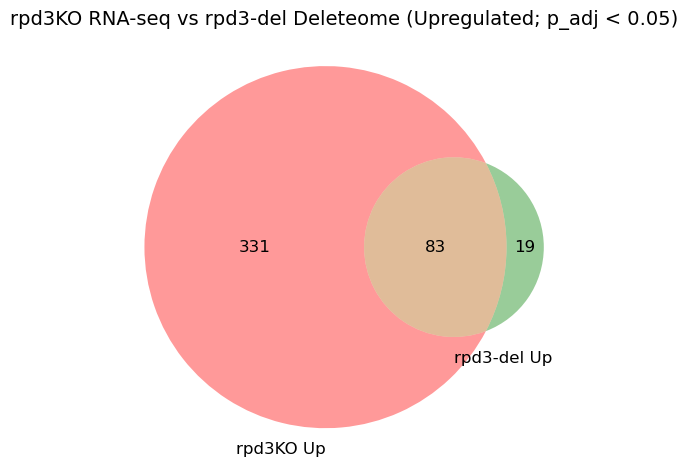

Plotting Venn Diagram for Sin3KO RNA-seq vs sin3-del (Upregulated; p_adj < 0.05):
  Sin3KO Up (size=433): ['YOR019W', 'YNR058W', 'YBL065W', 'YOL155C', 'YNL093W', 'YIL155C', 'YER152C', 'YLR081W', 'YLL059C', 'YPR064W']
  sin3-del Up (size=69): ['YBR222C', 'YNL134C', 'YHL030W', 'YEL012W', 'YPL134C', 'YBR047W', 'YOR383C', 'YMR196W', 'YOR152C', 'YDR018C']


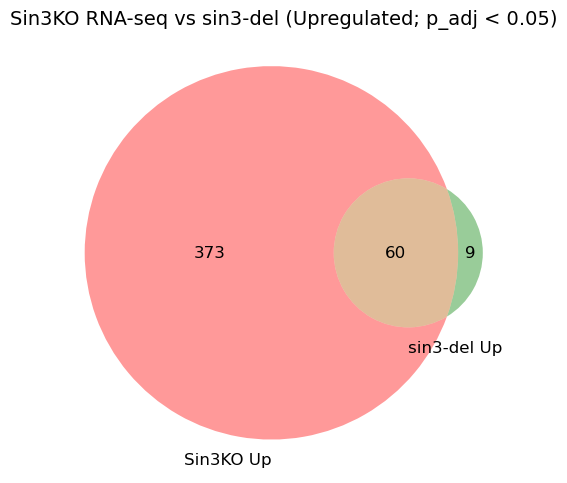

Downregulated Genes:
Plotting Venn Diagram for rpd3KO RNA-seq vs rpd3-del Deleteome (Downregulated; p_adj < 0.05):
  rpd3KO Down (size=267): ['YOL157C', 'YGL001C', 'YDR019C', 'YPL014W', 'YHR214W', 'YML003W', 'YGL204C', 'YHR177W', 'YOR178C', 'YHR215W']
  rpd3-del Down (size=66): ['YHR055C', 'YCR107W', 'YOR347C', 'YOL165C', 'YOL157C', 'YIR043C', 'YDR019C', 'YGR295C', 'YNL111C', 'YBL098W']


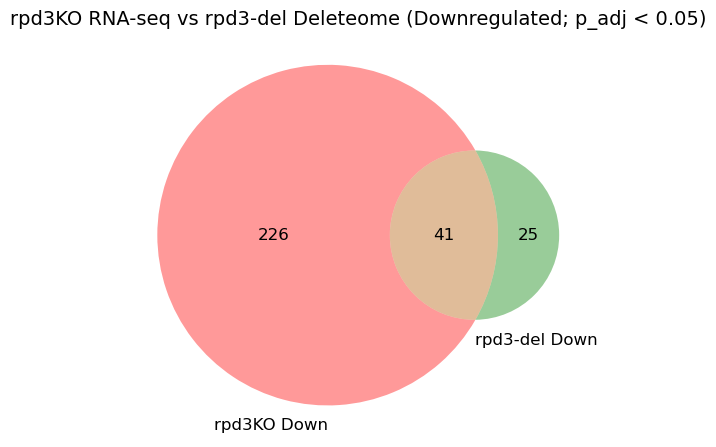

Plotting Venn Diagram for Sin3KO RNA-seq vs sin3-del Deleteome (Downregulated; p_adj < 0.05):
  Sin3KO Down (size=287): ['YOL157C', 'YGL001C', 'YDR019C', 'YEL070W', 'YPL014W', 'YHR214W', 'YML003W', 'YGL204C', 'YGR059W', 'YHR177W']
  sin3-del Down (size=56): ['YHR055C', 'YCR107W', 'YHR049W', 'YOL165C', 'YOR347C', 'YDR019C', 'YGR295C', 'YNL111C', 'YJR155W', 'YBL098W']


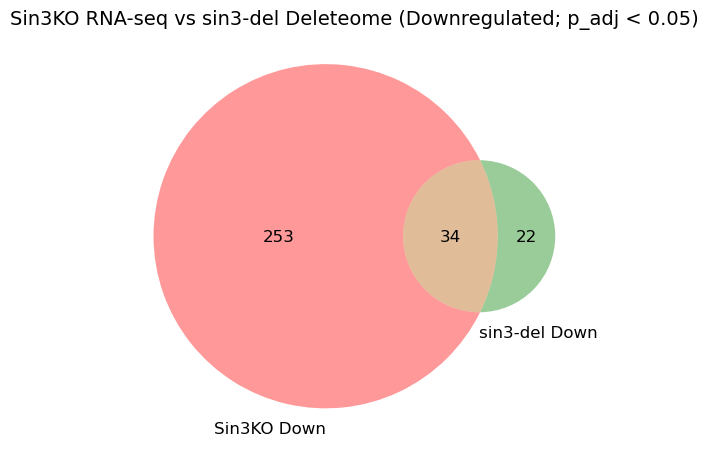

In [11]:
#Plot Venn diagrams with diagnostics
print("Upregulated Genes:")
plot_venn(rpd3_up, rpd3_del_up, 'rpd3KO Up', 'rpd3-del Up', 'rpd3KO RNA-seq vs rpd3-del Deleteome (Upregulated; p_adj < 0.05)')
plot_venn(sin3_up, sin3_del_up, 'Sin3KO Up', 'sin3-del Up', 'Sin3KO RNA-seq vs sin3-del (Upregulated; p_adj < 0.05)')

print("Downregulated Genes:")
plot_venn(rpd3_down, rpd3_del_down, 'rpd3KO Down', 'rpd3-del Down', 'rpd3KO RNA-seq vs rpd3-del Deleteome (Downregulated; p_adj < 0.05)')
plot_venn(sin3_down, sin3_del_down, 'Sin3KO Down', 'sin3-del Down', 'Sin3KO RNA-seq vs sin3-del Deleteome (Downregulated; p_adj < 0.05)')

In [14]:
#Change Venns to color-code thick solid outlines (no fills)
#Up DEG comparison → outlines in dark red & light red.
#Down DEG comparison → outlines in dark blue & sky blue.

from matplotlib_venn import venn2, venn2_circles

def plot_venn_up(set1, set2, label1, label2, title, color1='darkred', color2='lightcoral'):
    set1 = set(map(str, set1))
    set2 = set(map(str, set2))
    
    print(f"Plotting Venn Diagram for {title}:")
    print(f"  {label1} (size={len(set1)}): {list(set1)[:10]}")
    print(f"  {label2} (size={len(set2)}): {list(set2)[:10]}")

    if len(set1) > 0 and len(set2) > 0:
        plt.figure(figsize=(6, 6))

        #Plot the Venn diagram without fills
        venn = venn2([set1, set2], (label1, label2), set_colors=('white', 'white'))
        
        #Draw custom outlines
        venn_circles = venn2_circles([set1, set2], linestyle='solid', linewidth=3)
        venn_circles[0].set_edgecolor(color1)
        venn_circles[1].set_edgecolor(color2)
        
        #Increase label font size
        for label_id in ('10', '01', '11'):
            label = venn.get_label_by_id(label_id)
            if label:
                label.set_fontsize(12)

        plt.title(title, fontsize=14)
        plt.show()
    else:
        print(f"Skipping {title} due to empty set(s): {label1} size={len(set1)}, {label2} size={len(set2)}")


In [15]:
#For down genes: 
def plot_venn_down(set1, set2, label1, label2, title, color1='darkblue', color2='skyblue'):
    set1 = set(map(str, set1))
    set2 = set(map(str, set2))
    
    print(f"Plotting Venn Diagram for {title}:")
    print(f"  {label1} (size={len(set1)}): {list(set1)[:10]}")
    print(f"  {label2} (size={len(set2)}): {list(set2)[:10]}")

    if len(set1) > 0 and len(set2) > 0:
        plt.figure(figsize=(6, 6))

        # Plot the Venn diagram without fills
        venn = venn2([set1, set2], (label1, label2), set_colors=('white', 'white'))
        
        # Draw custom outlines
        venn_circles = venn2_circles([set1, set2], linestyle='solid', linewidth=3)
        venn_circles[0].set_edgecolor(color1)
        venn_circles[1].set_edgecolor(color2)
        
        # Increase label font size
        for label_id in ('10', '01', '11'):
            label = venn.get_label_by_id(label_id)
            if label:
                label.set_fontsize(12)

        plt.title(title, fontsize=14)
        plt.show()
    else:
        print(f"Skipping {title} due to empty set(s): {label1} size={len(set1)}, {label2} size={len(set2)}")


Upregulated Genes:
Plotting Venn Diagram for rpd3KO RNA-seq vs rpd3-del Deleteome (Upregulated; p_adj < 0.05):
  rpd3KO Up (size=414): ['YOR019W', 'YLR284C', 'YBL065W', 'YOL155C', 'YNL093W', 'YIL155C', 'YER152C', 'YLL059C', 'YPR064W', 'YHL024W']
  rpd3-del Up (size=102): ['YBR222C', 'YOR383C', 'YOR152C', 'YNL033W', 'YHR079C-A', 'YOL155C', 'YLL046C', 'YGL081W', 'YIL072W', 'YJL153C']


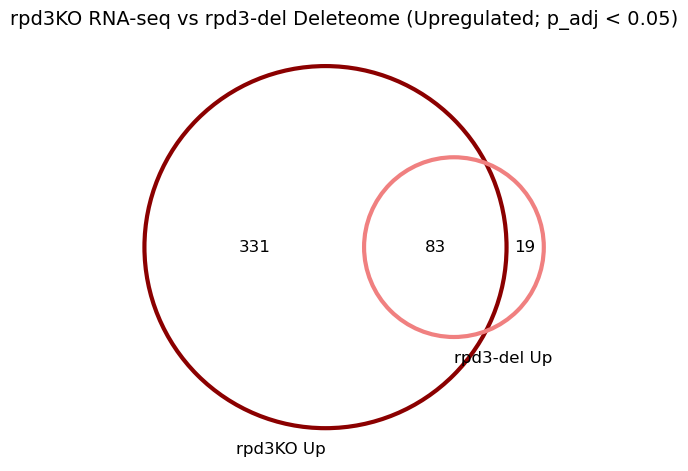

Plotting Venn Diagram for Sin3KO RNA-seq vs sin3-del (Upregulated; p_adj < 0.05):
  Sin3KO Up (size=433): ['YOR019W', 'YNR058W', 'YBL065W', 'YOL155C', 'YNL093W', 'YIL155C', 'YER152C', 'YLR081W', 'YLL059C', 'YPR064W']
  sin3-del Up (size=69): ['YBR222C', 'YNL134C', 'YHL030W', 'YEL012W', 'YPL134C', 'YBR047W', 'YOR383C', 'YMR196W', 'YOR152C', 'YDR018C']


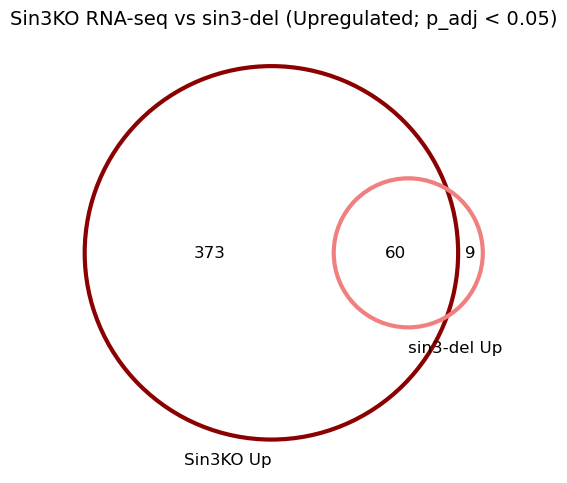

In [16]:
print("Upregulated Genes:")
plot_venn_up(rpd3_up, rpd3_del_up, 'rpd3KO Up', 'rpd3-del Up', 'rpd3KO RNA-seq vs rpd3-del Deleteome (Upregulated; p_adj < 0.05)')
plot_venn_up(sin3_up, sin3_del_up, 'Sin3KO Up', 'sin3-del Up', 'Sin3KO RNA-seq vs sin3-del (Upregulated; p_adj < 0.05)')

Downregulated Genes:
Plotting Venn Diagram for rpd3KO RNA-seq vs rpd3-del Deleteome (Downregulated; p_adj < 0.05):
  rpd3KO Down (size=267): ['YOL157C', 'YGL001C', 'YDR019C', 'YPL014W', 'YHR214W', 'YML003W', 'YGL204C', 'YHR177W', 'YOR178C', 'YHR215W']
  rpd3-del Down (size=66): ['YHR055C', 'YCR107W', 'YOR347C', 'YOL165C', 'YOL157C', 'YIR043C', 'YDR019C', 'YGR295C', 'YNL111C', 'YBL098W']


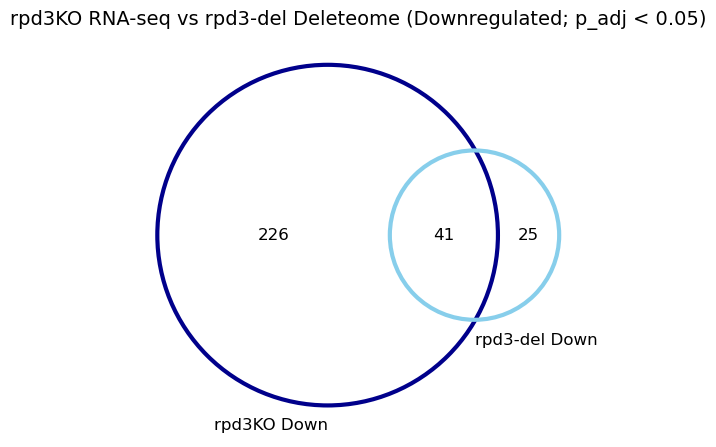

Plotting Venn Diagram for Sin3KO RNA-seq vs sin3-del Deleteome (Downregulated; p_adj < 0.05):
  Sin3KO Down (size=287): ['YOL157C', 'YGL001C', 'YDR019C', 'YEL070W', 'YPL014W', 'YHR214W', 'YML003W', 'YGL204C', 'YGR059W', 'YHR177W']
  sin3-del Down (size=56): ['YHR055C', 'YCR107W', 'YHR049W', 'YOL165C', 'YOR347C', 'YDR019C', 'YGR295C', 'YNL111C', 'YJR155W', 'YBL098W']


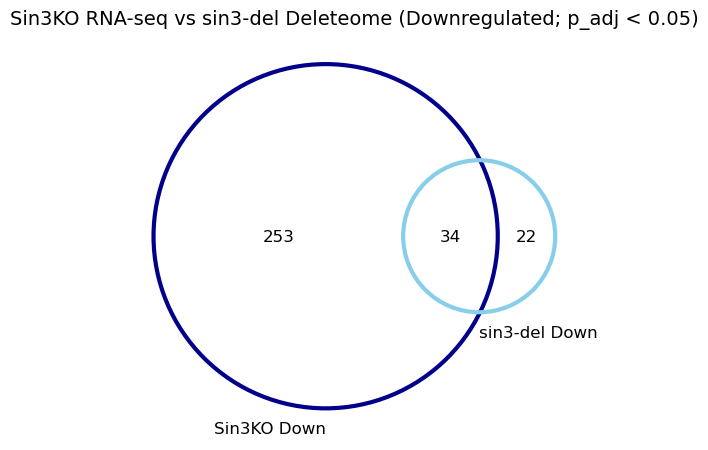

In [17]:
print("Downregulated Genes:")
plot_venn_down(rpd3_down, rpd3_del_down, 'rpd3KO Down', 'rpd3-del Down', 'rpd3KO RNA-seq vs rpd3-del Deleteome (Downregulated; p_adj < 0.05)')
plot_venn_down(sin3_down, sin3_del_down, 'Sin3KO Down', 'sin3-del Down', 'Sin3KO RNA-seq vs sin3-del Deleteome (Downregulated; p_adj < 0.05)')

Upregulated Genes:
Plotting Venn Diagram for Ume6KO RNA-seq vs Rpd3KO Deleteome (Upregulated; p_adj < 0.05):
  Ume6KO Up (size=786): ['YKL030W', 'YOR019W', 'YDR019C', 'YNR058W', 'YKL015W', 'YOR178C', 'YDR218C', 'YDR016C', 'YDR406W', 'YBL065W']
  rpd3-del Up (size=102): ['YBR222C', 'YOR383C', 'YOR152C', 'YNL033W', 'YHR079C-A', 'YOL155C', 'YLL046C', 'YGL081W', 'YIL072W', 'YJL153C']


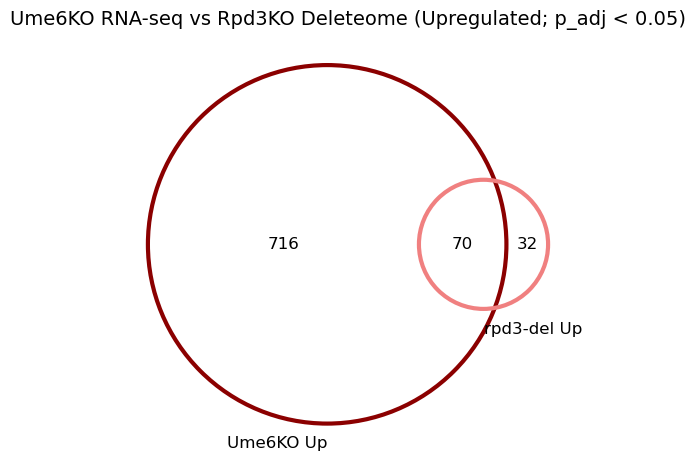

Plotting Venn Diagram for Ume6KO RNA-seq vs Sin3KO Deleteome (Upregulated; p_adj < 0.05):
  Ume6KO Up (size=786): ['YKL030W', 'YOR019W', 'YDR019C', 'YNR058W', 'YKL015W', 'YOR178C', 'YDR218C', 'YDR016C', 'YDR406W', 'YBL065W']
  sin3-del Up (size=69): ['YBR222C', 'YNL134C', 'YHL030W', 'YEL012W', 'YPL134C', 'YBR047W', 'YOR383C', 'YMR196W', 'YOR152C', 'YDR018C']


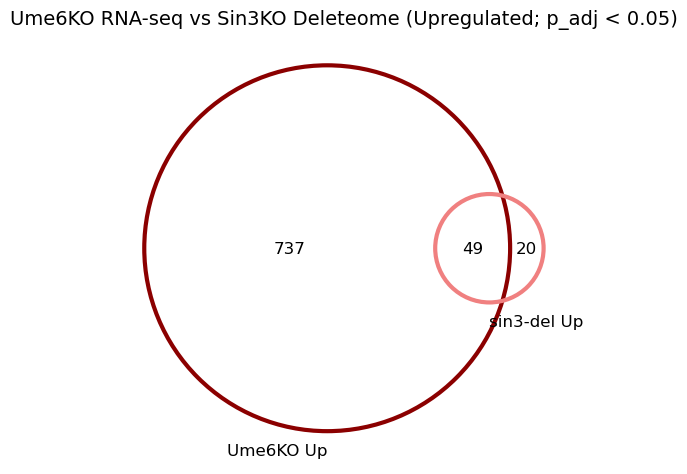

In [19]:
#Ume6KO case: 
ume6_up = set(bulk_rna_up['Ume6KO'].dropna().astype(str))

#Down genes: 
ume6_down = set(bulk_rna_data_down['Ume6KO'].dropna().astype(str))

#Since Deleteome dataset doesn't have Ume6-del, we'd rather compare the Ume6KO RNA-seq signatures with rpd3-del & sin3-del from Deleteome. 
print("Upregulated Genes:")
plot_venn_up(ume6_up, rpd3_del_up, 'Ume6KO Up', 'rpd3-del Up', 'Ume6KO RNA-seq vs Rpd3KO Deleteome (Upregulated; p_adj < 0.05)')
plot_venn_up(ume6_up, sin3_del_up, 'Ume6KO Up', 'sin3-del Up', 'Ume6KO RNA-seq vs Sin3KO Deleteome (Upregulated; p_adj < 0.05)')

Plotting Venn Diagram for Ume6KO RNA-seq vs Rpd3KO Deleteome (Downregulated; p_adj < 0.05):
  Ume6KO Down (size=263): ['YPL116W', 'YJR153W', 'YLR183C', 'YPR036W', 'YML056C', 'YDR050C', 'YOR264W', 'YBR265W', 'YNL145W', 'YPL255W']
  rpd3-del Down (size=66): ['YHR055C', 'YCR107W', 'YOR347C', 'YOL165C', 'YOL157C', 'YIR043C', 'YDR019C', 'YGR295C', 'YNL111C', 'YBL098W']


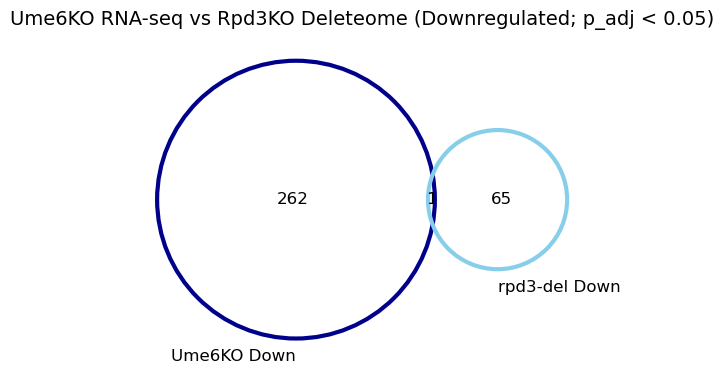

Plotting Venn Diagram for Ume6KO RNA-seq vs Sin3KO Deleteome (Downregulated; p_adj < 0.05):
  Ume6KO Down (size=263): ['YPL116W', 'YJR153W', 'YLR183C', 'YPR036W', 'YML056C', 'YDR050C', 'YOR264W', 'YBR265W', 'YNL145W', 'YPL255W']
  sin3-del Down (size=56): ['YHR055C', 'YCR107W', 'YHR049W', 'YOL165C', 'YOR347C', 'YDR019C', 'YGR295C', 'YNL111C', 'YJR155W', 'YBL098W']


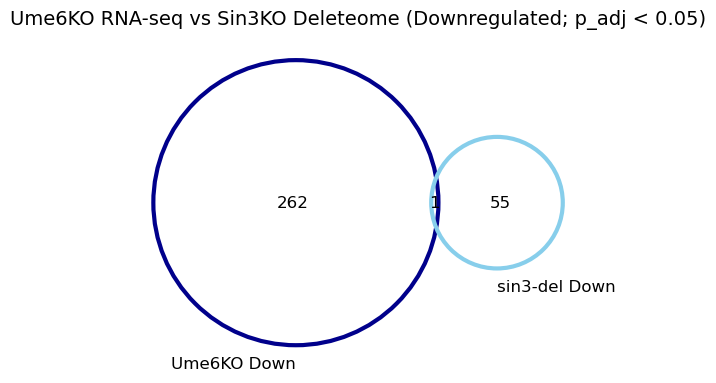

In [20]:
#Down genes: 
plot_venn_down(ume6_down, rpd3_del_down, 'Ume6KO Down', 'rpd3-del Down', 'Ume6KO RNA-seq vs Rpd3KO Deleteome (Downregulated; p_adj < 0.05)')
plot_venn_down(ume6_down , sin3_del_down, 'Ume6KO Down', 'sin3-del Down', 'Ume6KO RNA-seq vs Sin3KO Deleteome (Downregulated; p_adj < 0.05)')

#Julien: see when we use down DEGs, the overlap massively drops! (for up, we still have substantial overlaps) => talking about ume6!! 

In [21]:
#Let's take an overlap of rpd3_up with all these 7 core rpd3/HDAC complexes:

red_conditions = [
    'dep1-del vs. wt',
    'pho23-del vs. wt',
    'rpd3-del vs. wt',
    'rxt2-del vs. wt',
    'sap30-del vs. wt',
    'sds3-del vs. wt',
    'sin3-del vs. wt'
]

#Loop through each condition, extract genes & find the intersection
for condition in red_conditions:
    condition_genes = set(map(str, condition_upregulated.get(condition, [])))  #Extract genes per condition
    common_genes = rpd3_up & condition_genes  #Find intersection with rpd3_up
    print(f"Condition: {condition}")
    print(f"Common genes: {common_genes}")
    print(f"Number of common genes: {len(common_genes)}")
    print("-" * 50) #print a line of 50 dashes (-) in Python 


Condition: dep1-del vs. wt
Common genes: {'YHL030W', 'YEL012W', 'YPL134C', 'YBR047W', 'YOR383C', 'YDL199C', 'YDR018C', 'YDR374C', 'YHR079C-A', 'YCL026C-B', 'YLL046C', 'YGL081W', 'YOL131W', 'YIL072W', 'YIL024C', 'YGR110W', 'YGR149W', 'YGL156W', 'YJL153C', 'YMR191W', 'YKR009C', 'YPL111W', 'YLR438W', 'YBR006W', 'YGR131W', 'YHR137W', 'YHR138C', 'YHR014W', 'YJL163C', 'YDR285W', 'YML042W', 'YBR184W', 'YKL093W', 'YDR034W-B', 'YBR046C', 'YGL249W', 'YLR031W', 'YER096W', 'YGL183C', 'YPL017C', 'YJR095W', 'YJL089W', 'YOR374W', 'YMR034C', 'YNL092W', 'YGR053C', 'YPL119C', 'YJL137C', 'YER179W', 'YJL103C', 'YGL104C', 'YMR040W', 'YGL205W', 'YDL169C', 'YGL250W', 'YKL086W', 'YGR225W', 'YDR446W'}
Number of common genes: 58
--------------------------------------------------
Condition: pho23-del vs. wt
Common genes: {'YBR047W', 'YOR383C', 'YGR110W', 'YGR149W', 'YGL156W', 'YJL153C', 'YBR006W', 'YHR138C', 'YJL163C', 'YKL093W', 'YDR034W-B', 'YER096W', 'YMR034C', 'YNL092W', 'YGR053C', 'YJL137C', 'YGL104C', 'YMR

In [22]:
#Loop through each condition, extract genes & find the intersection for Sin3 
for condition in red_conditions:
    condition_genes = set(map(str, condition_upregulated.get(condition, [])))  #Extract genes per condition
    common_genes = sin3_up & condition_genes  #Find intersection with Sin3_up
    print(f"Condition: {condition}")
    print(f"Common genes: {common_genes}")
    print(f"Number of common genes: {len(common_genes)}")
    print("-" * 50) #print a line of 50 dashes (-) in Python 

Condition: dep1-del vs. wt
Common genes: {'YHL030W', 'YEL012W', 'YPL134C', 'YBR047W', 'YOR383C', 'YMR196W', 'YDL199C', 'YDR018C', 'YDR374C', 'YHR079C-A', 'YCL026C-B', 'YLL046C', 'YGL081W', 'YOL131W', 'YIL072W', 'YIL024C', 'YGR110W', 'YGR149W', 'YGL156W', 'YJL153C', 'YMR191W', 'YKR009C', 'YJL106W', 'YPL111W', 'YLR438W', 'YBR006W', 'YGR131W', 'YHR137W', 'YHR138C', 'YHR014W', 'YJL163C', 'YDR285W', 'YML042W', 'YBR184W', 'YKL093W', 'YDR034W-B', 'YBR046C', 'YGL249W', 'YLR031W', 'YER096W', 'YGL183C', 'YPL017C', 'YJR095W', 'YJL089W', 'YOR374W', 'YMR034C', 'YNL092W', 'YGR053C', 'YPL119C', 'YJL137C', 'YER179W', 'YJL103C', 'YGL104C', 'YMR040W', 'YGL205W', 'YDL169C', 'YGL250W', 'YKL086W', 'YGR225W', 'YDR446W'}
Number of common genes: 60
--------------------------------------------------
Condition: pho23-del vs. wt
Common genes: {'YBR047W', 'YOR383C', 'YGR110W', 'YGR149W', 'YGL156W', 'YJL153C', 'YBR006W', 'YHR138C', 'YJL163C', 'YKL093W', 'YDR034W-B', 'YER096W', 'YMR034C', 'YNL092W', 'YGR053C', 'YJL

We can visualize the overlap (e.g. number of common genes) between rpd3_up, sin3_up, and ume6_up against the 7 core Rpd3/HDAC complex KO conditions using a simple overlap heatmap.

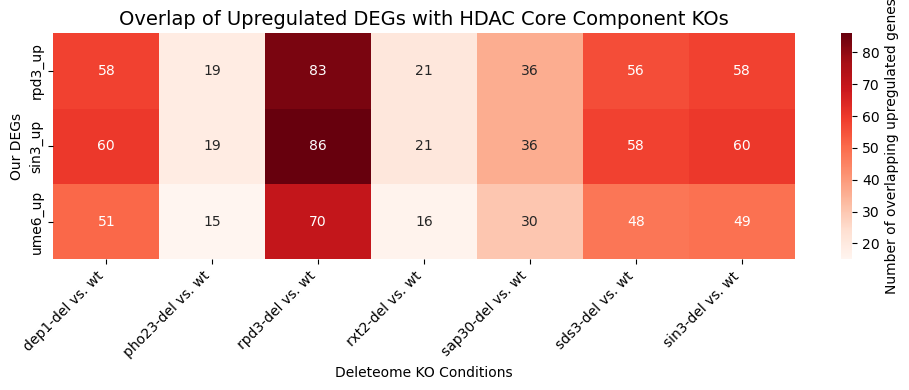

In [23]:
import seaborn as sns

#Define your core HDAC KO conditions
red_conditions = [
    'dep1-del vs. wt',
    'pho23-del vs. wt',
    'rpd3-del vs. wt',
    'rxt2-del vs. wt',
    'sap30-del vs. wt',
    'sds3-del vs. wt',
    'sin3-del vs. wt'
]

#Initialize the matrix
overlap_counts = pd.DataFrame(index=['rpd3_up', 'sin3_up', 'ume6_up'], columns=red_conditions)

#Fill the matrix with overlap counts
for condition in red_conditions:
    condition_genes = set(map(str, condition_upregulated.get(condition, [])))  # safely handle missing
    overlap_counts.loc['rpd3_up', condition] = len(rpd3_up & condition_genes)
    overlap_counts.loc['sin3_up', condition] = len(sin3_up & condition_genes)
    overlap_counts.loc['ume6_up', condition] = len(ume6_up & condition_genes)

#Convert to integers
overlap_counts = overlap_counts.astype(int)

#Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(
    overlap_counts,
    annot=True,
    fmt='d',
    cmap='Reds',
    cbar_kws={'label': 'Number of overlapping upregulated genes'}
)

plt.title("Overlap of Upregulated DEGs with HDAC Core Component KOs", fontsize=14)
plt.xlabel("Deleteome KO Conditions")
plt.ylabel("Our DEGs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [24]:
from scipy.stats import hypergeom
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [25]:
total_unique_genes = data_pd['geneSymbol'].nunique()
print(f"Total unique genes in Deleteome: {total_unique_genes}")

Total unique genes in Deleteome: 6109


- Hypergeometric test & Representation Factor: A hypergeometric test is a statistical method used to determine the significance of overlap between two sets, such as gene lists. It answers the question: If we randomly selected a certain number of items from a population, what is the probability that we would observe at least as many overlaps as we did? This test is particularly useful in genomics and bioinformatics when comparing gene sets to assess whether the observed overlap is more than would be expected by chance. In our context, the test helps evaluate whether the overlap between the knockout profiles in the deleteome data and the differentially expressed genes in the RNA-seq data is statistically significant.
The probability of finding x overlapping genes can be calculated using the hypergeometric probability formula: C(D, x) * C(N-D, n-x) / C(N,n)

If x is less than the expected number of overlapping genes, the probability of finding x or fewer genes is: Prob = sum (i=0 to i=x) [ C(D, i) * C(N-D, n-i) / C(N,n) ]

If x is greater than the expected number of overlapping genes, the probability of finding x or more genes is: Prob = 1- sum (i=0 to i=(x-1)) [ C(D, i) * C(N-D, n-i) / C(N,n) ]

The representation factor (RF) quantifies the enrichment level of overlap between two sets, calculated as the observed overlap count divided by the expected overlap count (calculated based on the sizes of the gene sets and the total gene pool). An RF > 1 indicates more overlap than expected by chance, suggesting a potential biological relationship between the compared sets. Conversely, an RF < 1 would imply less overlap than expected, which may suggest the sets are not related. RF values help interpret the biological relevance of the overlaps in conjunction with the hypergeometric test's p-value.

Mathematically, RF is the number of overlapping genes divided by the expected number of overlapping genes drawn from two independent groups.

- RF > 1 indicates more overlap than expected of two independent groups,
- RF < 1 indicates less overlap than expected
- RF=1 indicates that the two groups by the number of genes expected for independent groups of genes.


x = # of genes in common between two groups. n = # of genes in group 1. D = # of genes in group 2. N = total genes, in this case the 17611 genes with good spots on the Kim lab full genome chips. C(a,b) is the number of combinations of things taken b at a time.

The representation factor = x / expected #genes. Expected #genes = (n * D) / N

In [26]:
#Total genes assumed for the test
total_genes = total_unique_genes
p_value_threshold = 0.05

#Lists to store results
results_up_list = []
results_down_list = []

#Iterate over all bulk RNA-seq conditions for both up and downregulated data
for bulk_condition in bulk_rna_up.columns:
    # Upregulated genes
    bulk_genes_up = set(bulk_rna_up[bulk_condition].dropna().astype(str))
    for del_condition, deleteome_genes in condition_upregulated.items():
        overlap_up = bulk_genes_up & set(deleteome_genes)
        overlap_count_up = len(overlap_up)
        
        #Hypergeometric test
        M = total_genes
        n = len(deleteome_genes)
        N = len(bulk_genes_up)
        k = overlap_count_up
        p_value_up = hypergeom.sf(k - 1, M, n, N)
        expected_overlap_up = (N * n) / M
        rf_up = overlap_count_up / expected_overlap_up if expected_overlap_up > 0 else float('inf')
        
        if p_value_up < p_value_threshold:
            results_up_list.append({
                'Condition': bulk_condition,
                'Knockout Profile': del_condition,
                'Overlap Count': overlap_count_up,
                'P-value': p_value_up,
                'Representation Factor': rf_up
            })

#Same for downregulated genes
for bulk_condition in bulk_rna_data_down.columns:
    bulk_genes_down = set(bulk_rna_data_down[bulk_condition].dropna().astype(str))
    for del_condition, deleteome_genes in condition_downregulated.items():
        overlap_down = bulk_genes_down & set(deleteome_genes)
        overlap_count_down = len(overlap_down)
        
        #Hypergeometric test
        n = len(deleteome_genes)
        N = len(bulk_genes_down)
        k = overlap_count_down
        p_value_down = hypergeom.sf(k - 1, M, n, N)
        expected_overlap_down = (N * n) / M
        rf_down = overlap_count_down / expected_overlap_down if expected_overlap_down > 0 else float('inf')
        
        if p_value_down < p_value_threshold:
            results_down_list.append({
                'Condition': bulk_condition,
                'Knockout Profile': del_condition,
                'Overlap Count': overlap_count_down,
                'P-value': p_value_down,
                'Representation Factor': rf_down
            })

results_up_df = pd.DataFrame(results_up_list)
results_down_df = pd.DataFrame(results_down_list)

In [27]:
from statsmodels.stats.multitest import multipletests

When tests are not independent, standard FDR correction methods like the Benjamini-Hochberg (BH) approach may not control the false discovery rate adequately because BH assumes independence among tests. The Benjamini-Yekutieli (BY) correction is designed to handle such dependencies by being more conservative. This means that the BY correction lowers the threshold for significance even more than BH, which reduces the number of false positives when tests are dependent but also may reduce the number of significant findings.

For example, in deleteome gene expression profiling, if certain knockout profiles share similar biological pathways or influence overlapping gene networks (which is the case), the test results may show dependencies due to these shared biological programs, making the BY correction more appropriate for controlling false discoveries.

In [28]:
#Do a more conservative Benjamini-Yekutieli (BY) correction:
#This adjustment is particularly useful as our tests are not independent => certain genes are co-expressed or functionally related, 
#so the presence or absence of one gene's differential expression might influence the likelihood of observing similar results in other genes. 
#In this case, testing each gene's differential expression separately might lead to dependencies among the tests.

#Apply BY correction to the p-values in both results_up_df & results_down_df
results_up_df['Adjusted P-value BY'] = multipletests(results_up_df['P-value'], method='fdr_by')[1]
results_down_df['Adjusted P-value BY'] = multipletests(results_down_df['P-value'], method='fdr_by')[1]

#Set FDR threshold
fdr_threshold = 0.05

#Filter based on FDR threshold: 
filtered_up_df = results_up_df[results_up_df['Adjusted P-value BY'] < fdr_threshold]
filtered_down_df = results_down_df[results_down_df['Adjusted P-value BY'] < fdr_threshold]

#Calculate the number of genes filtered out
genes_filtered_up = len(results_up_df) - len(filtered_up_df)
genes_filtered_down = len(results_down_df) - len(filtered_down_df)

print("Number of genes filtered out (Upregulated):", genes_filtered_up)
print("Number of genes filtered out (Downregulated):", genes_filtered_down)

Number of genes filtered out (Upregulated): 381
Number of genes filtered out (Downregulated): 333


In [29]:
filtered_up_df['Condition'].value_counts() #based on upregulated DEG overlap 

#Previously, 209 KOs overlapped with E6R 

Condition
Ume6KO    241
E6R       216
TSA       205
rpd3KO    163
Sin3KO    160
Name: count, dtype: int64

In [30]:
filtered_down_df['Condition'].value_counts() #based on downregulated DEG overlap 

#Previously, 81 KOs overlapped with E6R 

Condition
E6R       89
Ume6KO    68
rpd3KO    66
Sin3KO    56
TSA       39
Name: count, dtype: int64

In [36]:
#E6R Venn for up & down: after 2 step BY-FDR correction 
E6R_up = filtered_up_df[filtered_up_df['Condition']== 'E6R'] 
E6R_down = filtered_down_df[filtered_down_df['Condition']== 'E6R'] 

In [37]:
E6R_del_up = set(map(str, E6R_up.get('Knockout Profile', [])))
E6R_del_down= set(map(str, E6R_down.get('Knockout Profile', [])))

In [34]:
#Modify the plotting color for the Venn diagram:

def plot_venn_hypergeometric(set1, set2, label1, label2, title, color1='darkred', color2='skyblue'):
    set1 = set(map(str, set1))
    set2 = set(map(str, set2))
    
    print(f"Plotting Venn Diagram for {title}:")
    print(f"  {label1} (size={len(set1)}): {list(set1)[:10]}")
    print(f"  {label2} (size={len(set2)}): {list(set2)[:10]}")

    if len(set1) > 0 and len(set2) > 0:
        plt.figure(figsize=(6, 6))

        #Plot the Venn diagram without fills
        venn = venn2([set1, set2], (label1, label2), set_colors=('white', 'white'))
        
        #Draw custom outlines
        venn_circles = venn2_circles([set1, set2], linestyle='solid', linewidth=3)
        venn_circles[0].set_edgecolor(color1)
        venn_circles[1].set_edgecolor(color2)
        
        #Increase label font size
        for label_id in ('10', '01', '11'):
            label = venn.get_label_by_id(label_id)
            if label:
                label.set_fontsize(12)

        plt.title(title, fontsize=14)
        plt.show()
    else:
        print(f"Skipping {title} due to empty set(s): {label1} size={len(set1)}, {label2} size={len(set2)}")


Plotting Venn Diagram for KO profiles similar to E6R treatment:
  By upregulated DEG overlap (size=216): ['vps1-del vs. wt', 'arp8-del vs. wt', 'med1-del vs. wt', 'cka2-del vs. wt', 'npl6-del vs. wt', 'sla1-del vs. wt', 'ipk1-del vs. wt', 'thr4-del vs. wt', 'new1-del vs. wt', 'kin3-del vs. wt']
  By downregulated DEG overlap (size=89): ['cdc40-del vs. wt', 'pib2-del vs. wt', 'ipk1-del vs. wt', 'med20-del vs. wt', 'rad6-del vs. wt', 'tup1-del vs. wt', 'uaf30-del vs. wt', 'tco89-del vs. wt', 'msn5-del vs. wt', 'spt20-del vs. wt']


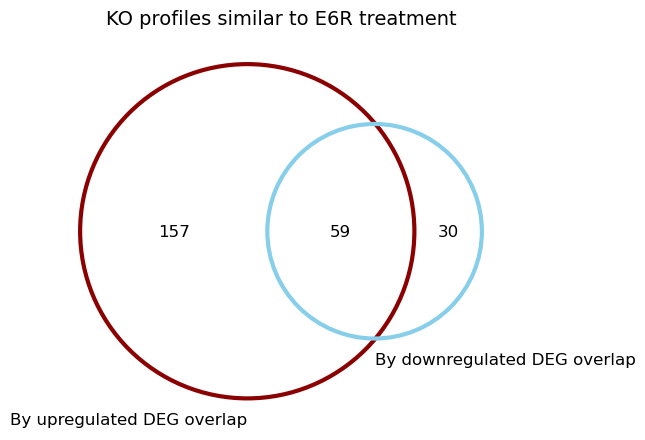

In [38]:
plot_venn_hypergeometric(E6R_del_up, E6R_del_down, 'By upregulated DEG overlap', 'By downregulated DEG overlap', 'KO profiles similar to E6R treatment')

In [39]:
#E6R overlaps between up & down DGEs: 
#Is there a different mode of action? 
E6R_del_overlap= E6R_del_up.intersection(E6R_del_down) 
E6R_del_overlap

#vps genes: https://www.molbiolcell.org/doi/10.1091/mbc.11.12.4105 
#gcn5: histone acetyltransferase HAT (opp of HDAC) 
#spt20 is shared with TSA, rpd3KO & sin3KO (related to HATs; must be acting together with gcn5) 
#med: MT-genes
#opi3 

{'ada2-del vs. wt',
 'ccr4-del vs. wt',
 'cho2-del vs. wt',
 'cst6-del vs. wt',
 'ctr9-del vs. wt',
 'def1-del vs. wt',
 'did4-del vs. wt',
 'eaf7-del vs. wt',
 'fmp38-del vs. wt',
 'gcn5-del vs. wt',
 'grr1-del vs. wt',
 'hfm1-del vs. wt',
 'hse1-del vs. wt',
 'ies6-del vs. wt',
 'ino4-del vs. wt',
 'ipk1-del vs. wt',
 'kar3-del vs. wt',
 'lsm6-del vs. wt',
 'med15-del vs. wt',
 'med16-del vs. wt',
 'med2-del vs. wt',
 'med9-del vs. wt',
 'ngg1-del vs. wt',
 'not4-del vs. wt',
 'opi3-del vs. wt',
 'pep3-del vs. wt',
 'pep5-del vs. wt',
 'pep7-del vs. wt',
 'rad6-del vs. wt',
 'ram1-del vs. wt',
 'reg1-del vs. wt',
 'rnr4-del vs. wt',
 'rny1-del vs. wt',
 'rpb9-del vs. wt',
 'rpn13-del vs. wt',
 'sac3-del vs. wt',
 'sfp1-del vs. wt',
 'sis2-del vs. wt',
 'snf12-del vs. wt',
 'snf2-del vs. wt',
 'snf6-del vs. wt',
 'spt20-del vs. wt',
 'srn2-del vs. wt',
 'ssn6-del vs. wt',
 'stp1-del vs. wt',
 'swa2-del vs. wt',
 'swi3-del vs. wt',
 'thp1-del vs. wt',
 'tlc1-del vs. wt',
 'tup1-del vs.

1. Yeast Phosphatidylinositol 3-Kinase Complex:

VPS15: Serine/threonine protein kinase involved in vacuolar protein sorting; functions as a membrane-associated complex with Vps34p. 


2. ESCRT (Endosomal Sorting Complex Required for Transport) Pathway:

DID4: Component of the ESCRT-III complex, involved in the multivesicular body (MVB) sorting pathway.
VPS25: Part of the ESCRT-II complex, plays a role in the MVB pathway.
VPS36: Another component of the ESCRT-II complex, involved in endosomal sorting.


3. Mediator Complex (Transcriptional Regulation):

MED15: Subunit of the Mediator complex, involved in transcriptional regulation.
MED16: Another Mediator complex subunit plays a role in transcription.
MED2: Component of the Mediator complex, involved in transcriptional activation.
MED9: Part of the Mediator complex, contributes to transcription regulation.

4. SAGA Complex (Histone Acetylation and Gene Expression):

ADA2: Transcriptional adaptor, component of the SAGA complex.
GCN5: Histone acetyltransferase, part of the SAGA complex.
NGG1: Also known as ADA3, component of the SAGA complex.
SPT20: Subunit of the SAGA complex, involved in chromatin modification.

5. CCR4-NOT Complex (mRNA Deadenylation and Transcription Regulation):

CCR4: Component of the CCR4-NOT complex, involved in mRNA deadenylation.
NOT4: Part of the CCR4-NOT complex, functions in transcriptional regulation.

6. SWI/SNF Chromatin Remodeling Complex:

SNF2: ATPase subunit of the SWI/SNF complex, involved in chromatin remodeling.
SNF6: Component of the SWI/SNF complex, plays a role in transcriptional activation.
SNF12: Also known as ARP7, part of the SWI/SNF complex.
SWI3: Subunit of the SWI/SNF complex, involved in chromatin remodeling.

7. VPS (Vacuolar Protein Sorting) Pathway:

VPS3: Involved in vacuolar protein sorting.
VPS8: Plays a role in endosomal tethering and vacuolar protein sorting.
VPS15: As mentioned, part of the phosphatidylinositol 3-kinase complex is involved in vacuolar protein sorting. 
VPS16: Component of the HOPS complex, involved in vacuole fusion.
VPS25: As mentioned, part of the ESCRT-II complex.
VPS36: As mentioned, component of the ESCRT-II complex.
VPS41: Involved in vacuolar trafficking and fusion.


8. TREX-2 Complex (mRNA Export):

SAC3: Component of the TREX-2 complex, involved in mRNA export.
THP1: Part of the TREX-2 complex, plays a role in transcription elongation and mRNA export.

9. Proteasome Regulatory Particle:

RPN13: Component of the 19S proteasome regulatory particle, involved in ubiquitin recognition.

10. Exosome Complex (RNA Processing and Degradation):

LSM6: Part of the Lsm complex, associated with RNA processing and degradation.

12. Other Notable Pathways/Complexes:

TUP1: General transcriptional corepressor, forms a complex with Ssn6.
SSN6: Works with Tup1 as a general transcriptional corepressor.
CTR9: Component of the Paf1 complex, involved in transcription elongation.
DEF1: Involved in DNA damage response and RNA polymerase degradation.
EAF7: Part of the NuA4 histone acetyltransferase complex.
IES6: Component of the INO80 chromatin remodeling complex.
INO4: Transcription factor involved in phospholipid biosynthesis regulation.
SFP1: Transcription factor involved in ribosomal protein gene expression.
UBP10: Ubiquitin-specific protease involved in gene silencing.
UBP3: Ubiquitin-specific protease, plays a role in protein trafficking.

In [40]:
def find_unique_overlaps(df, column_name='Knockout Profile'):
    condition_sets = {cond: set(df[df['Condition'] == cond][column_name]) for cond in df['Condition'].unique()}
    return condition_sets

from matplotlib_venn import venn2, venn3, venn3_circles
from upsetplot import UpSet

#Repeat UpSet plot: 
#After 2-step BY-based FDR correction: 
up_condition_sets = find_unique_overlaps(filtered_up_df)
down_condition_sets = find_unique_overlaps(filtered_down_df)

print("Unique & overlapping knockout profiles (upregulated):")
for cond, profiles in up_condition_sets.items():
    print(f"{cond}: {len(profiles)} unique profiles")

print("\nUnique and overlapping knockout profiles (downregulated):")
for cond, profiles in down_condition_sets.items():
    print(f"{cond}: {len(profiles)} unique profiles")


Unique & overlapping knockout profiles (upregulated):
rpd3KO: 163 unique profiles
Sin3KO: 160 unique profiles
Ume6KO: 241 unique profiles
TSA: 205 unique profiles
E6R: 216 unique profiles

Unique and overlapping knockout profiles (downregulated):
rpd3KO: 66 unique profiles
Sin3KO: 56 unique profiles
Ume6KO: 68 unique profiles
TSA: 39 unique profiles
E6R: 89 unique profiles


/home/olive0927/miniconda3/envs/scRNAseq_core_analysis/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/olive0927/miniconda3/envs/scRNAseq_core_analysis/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace

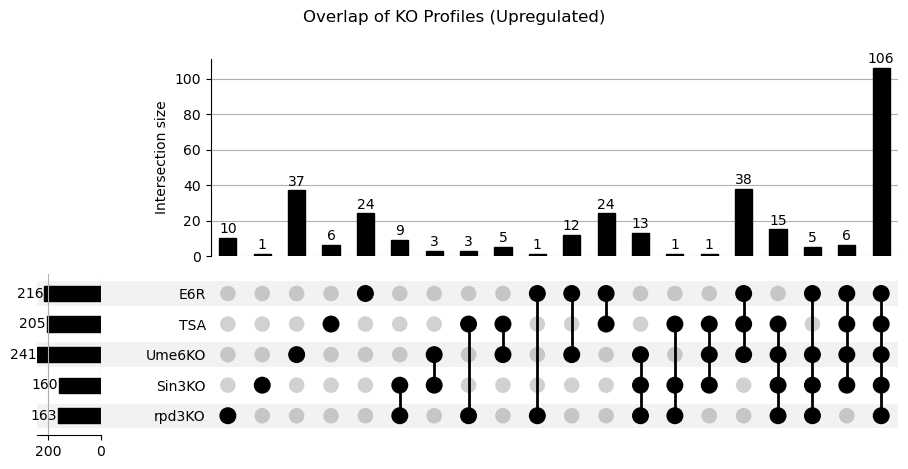

/home/olive0927/miniconda3/envs/scRNAseq_core_analysis/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/olive0927/miniconda3/envs/scRNAseq_core_analysis/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace

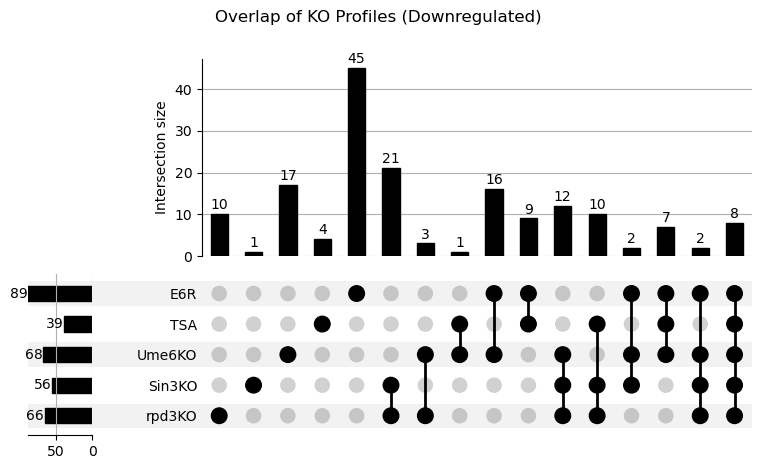

In [41]:
#Plot the numbers on the top

#Define color mapping for conditions
condition_colors = {
    'rpd3KO_DMSO': '#1f77b4',  #Blue
    'Sin3KO_DMSO': '#2ca02c',  #Green
    'WT-TSA': '#ffcc00',       #Yellow
    'WT-E6R': '#800080',       #Purple
}

def plot_upset(sets, title="Overlap of Knockout Profiles", colors=None):
    
    contents = from_contents(sets)

    #Create UpSet object
    upset = UpSet(contents, subset_size='count', show_counts='%d', sort_categories_by=None)
    fig = plt.figure(figsize=(10, 5))
    upset.plot(fig=fig)

    #Access axes for customization
    for axis in fig.axes:
        for patch in axis.patches:
            if colors:
                #Assign colors to conditions
                for condition, color in colors.items():
                    if condition in patch.get_label():
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')

    #Add title
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


up_condition_sets = find_unique_overlaps(filtered_up_df)
down_condition_sets = find_unique_overlaps(filtered_down_df)

from upsetplot import from_contents, UpSet

#Generate color-coded UpSet plots
plot_upset(up_condition_sets, title="Overlap of KO Profiles (Upregulated)", colors=condition_colors)
plot_upset(down_condition_sets, title="Overlap of KO Profiles (Downregulated)", colors=condition_colors)

In [42]:
bulk_rna_up.head()

,rpd3KO,Sin3KO,Ume6KO,TSA,E6R
0,YBR116C,YHR079C-A,YHR079C-A,YBR116C,YGR224W
1,YHR079C-A,YJR095W,YDR374C,YDR360W,YLL056C
2,YJR095W,YBL065W,YOL131W,YLR445W,YGR035C
3,YLR445W,YBR116C,YLL030C,YHR079C-A,YPL088W
4,YBL065W,YLR445W,YOR351C,YNL019C,YLR046C


In [44]:
bulk_rna_data_down.head()

,rpd3KO,Sin3KO,Ume6KO,TSA,E6R
0,YGR008C,YCR097W,YOR143C,YKL120W,YAL025C
1,YMR205C,YOR047C,YGR159C,YGR118W,YDR299W
2,YBR240C,YDR234W,YGL111W,YBR137W,YCR072C
3,YMR316W,YJL216C,YPR102C,YDR482C,YPL043W
4,YDR185C,YDR096W,YMR250W,YBR177C,YCR020W-B


In [45]:
#To store the overlaps 
output_up = []
output_down = []

#Extract the up & down DEGs from JO's bulk RNA-seq data: 
E6R_up = set(bulk_rna_up['E6R'].dropna().astype(str))
E6R_down = set(bulk_rna_data_down['E6R'].dropna().astype(str))

for condition in E6R_del_overlap:

    #Extract DEGs from each of the gene-del vs wt condition listed in "E6R_del_overlap" 
    condition_up = set(map(str, condition_upregulated.get(condition, [])))
    condition_down = set(map(str, condition_downregulated.get(condition, [])))

    #After that, we take an overlap with JO's RNA-seq data 
    E6R_up_overlap = E6R_up.intersection(condition_up)
    E6R_down_overlap = E6R_down.intersection(condition_down)


    if E6R_up_overlap:
        output_up.append({
            'Case': 'E6R_up',
            'Condition': condition,
            'Overlap Count': len(E6R_up_overlap), 
            'Overlap Targets': list(E6R_up_overlap)  # Convert set to list
            
        })

    if E6R_down_overlap:
        output_down.append({
            'Case': 'E6R_down',
            'Condition': condition,
            'Overlap Count': len(E6R_down_overlap), 
            'Overlap Targets': list(E6R_down_overlap)  # Convert set to list
            
        })

#sort by descending order of overlap count
df_up = pd.DataFrame(output_up).sort_values(by='Overlap Count', ascending=False)
df_down = pd.DataFrame(output_down).sort_values(by='Overlap Count', ascending=False)

In [46]:
df_up.head() #up targets

,Case,Condition,Overlap Count,Overlap Targets
37,E6R_up,ssn6-del vs. wt,133,"[YIR017C, YOR178C, YGR059W, YIL117C, YDR406W, ..."
11,E6R_up,opi3-del vs. wt,112,"[YOR178C, YIL117C, YDR070C, YNL093W, YPR127W, ..."
17,E6R_up,tup1-del vs. wt,109,"[YIR017C, YOR178C, YDR406W, YAR035W, YDR070C, ..."
57,E6R_up,ram1-del vs. wt,105,"[YIR017C, YOR178C, YDR406W, YPR127W, YDR070C, ..."
22,E6R_up,cst6-del vs. wt,95,"[YOR152C, YDR406W, YDR070C, YPR127W, YIL155C, ..."


In [47]:
df_down.head() #down targets

,Case,Condition,Overlap Count,Overlap Targets
11,E6R_down,opi3-del vs. wt,30,"[YMR058W, YAL059W, YAL025C, YJL157C, YML056C, ..."
29,E6R_down,spt20-del vs. wt,27,"[YHR049W, YNL134C, YJL157C, YLR355C, YDR399W, ..."
34,E6R_down,rpb9-del vs. wt,21,"[YJL157C, YLR355C, YML056C, YNL112W, YJR016C, ..."
31,E6R_down,sfp1-del vs. wt,21,"[YKL029C, YML056C, YDR399W, YHR216W, YBR092C, ..."
33,E6R_down,not4-del vs. wt,21,"[YAL059W, YKL029C, YML056C, YNL112W, YOL080C, ..."


In [49]:
#Load Excel with each sheet as a condition
file_path = "DESeq2_DEGs_yeast_09042025.xlsx"

wt_e6r_df = pd.read_excel(file_path, sheet_name='E6R_DEGs')
wt_e6r_df.head()

#Filter rows with adjusted p-value (padj) < 0.05
significant_degs = wt_e6r_df[wt_e6r_df['padj'] < 0.05]
len(significant_degs)

414

In [50]:
#Make a dictionary of significant log2FC & padj for DEGs: 
log2fc_dict = significant_degs.set_index('Systematic Name')['log2FoldChange'].to_dict()
padj_dict = significant_degs.set_index('Systematic Name')['padj'].to_dict()

In [51]:
#Function to sort genes by log2FC
def sort_genes_by_log2fc(overlap_targets, log2fc_dict):
    """
    Sort genes in descending order of log2FoldChange.
    """
    genes_with_fc = [(gene, log2fc_dict.get(gene, 0)) for gene in overlap_targets]
    sorted_genes = sorted(genes_with_fc, key=lambda x: x[1], reverse=True)  # Sort by log2FC
    return [gene[0] for gene in sorted_genes]  # Return only gene names

#Function to update the DataFrame with sorted genes
def update_overlap_targets(df, log2fc_dict):
    """
    Update the Overlap Targets column with genes sorted by log2FoldChange.
    """
    df['Overlap Targets'] = df['Overlap Targets'].apply(
        lambda x: ', '.join(sort_genes_by_log2fc(eval(x), log2fc_dict)) if isinstance(x, str) else x
    )
    return df

#Apply sorting to df_up & df_down (in descending order of log2FC)
df_up = update_overlap_targets(df_up, log2fc_dict)
df_down = update_overlap_targets(df_down, log2fc_dict)

df_up.head()

#let's fix the issues with sorting later.. 

,Case,Condition,Overlap Count,Overlap Targets
37,E6R_up,ssn6-del vs. wt,133,"[YIR017C, YOR178C, YGR059W, YIL117C, YDR406W, ..."
11,E6R_up,opi3-del vs. wt,112,"[YOR178C, YIL117C, YDR070C, YNL093W, YPR127W, ..."
17,E6R_up,tup1-del vs. wt,109,"[YIR017C, YOR178C, YDR406W, YAR035W, YDR070C, ..."
57,E6R_up,ram1-del vs. wt,105,"[YIR017C, YOR178C, YDR406W, YPR127W, YDR070C, ..."
22,E6R_up,cst6-del vs. wt,95,"[YOR152C, YDR406W, YDR070C, YPR127W, YIL155C, ..."


In [52]:
#Extract E6R condition from hypergeometric results: 
E6R_up_hypergeom = filtered_up_df[filtered_up_df['Condition']== 'E6R'] 
E6R_down_hypergeom = filtered_down_df[filtered_down_df['Condition']== 'E6R'] 

print(E6R_up_hypergeom.head()) 
print(E6R_down_hypergeom.head())

     Condition  Knockout Profile  Overlap Count       P-value  \
1077       E6R   ptc1-del vs. wt             57  6.509928e-38   
1078       E6R   tlc1-del vs. wt             87  7.516286e-49   
1080       E6R   swa2-del vs. wt             62  4.758719e-34   
1081       E6R  rad18-del vs. wt             13  1.617557e-12   
1082       E6R   asf1-del vs. wt             12  1.983204e-06   

      Representation Factor  Adjusted P-value BY  
1077               7.951884         1.824666e-35  
1078               6.254949         4.213475e-46  
1080               6.219343         1.013703e-31  
1081              12.447806         6.975147e-11  
1082               5.158902         4.000592e-05  
    Condition  Knockout Profile  Overlap Count       P-value  \
488       E6R   tlc1-del vs. wt              5  3.859313e-05   
490       E6R   swa2-del vs. wt              6  6.181308e-06   
491       E6R  vps16-del vs. wt              8  5.416584e-07   
492       E6R   sir2-del vs. wt              5 

In [53]:
#Step 1: Prepare Enrichment Data from Hypergeometric Analysis
enrichment_up = E6R_up_hypergeom[['Knockout Profile', 'Representation Factor', 'Adjusted P-value BY']]
enrichment_down = E6R_down_hypergeom[['Knockout Profile', 'Representation Factor', 'Adjusted P-value BY']]

#Rename columns for clarity
enrichment_up = enrichment_up.rename(columns={
    'Knockout Profile': 'Condition',
    'Representation Factor': 'Representation Factor',
    'Adjusted P-value BY': 'Adj_P_Val'
})

enrichment_down = enrichment_down.rename(columns={
    'Knockout Profile': 'Condition',
    'Representation Factor': 'Representation Factor',
    'Adjusted P-value BY': 'Adj_P_Val'
})

#Step 2: Merge enrichment data with df_up and df_down
df_up = df_up.merge(enrichment_up, on='Condition', how='left')
df_down = df_down.merge(enrichment_down, on='Condition', how='left')

df_up.head()

,Case,Condition,Overlap Count,Overlap Targets,Representation Factor,Adj_P_Val
0,E6R_up,ssn6-del vs. wt,133,"[YIR017C, YOR178C, YGR059W, YIL117C, YDR406W, ...",4.277426,3.111418e-53
1,E6R_up,opi3-del vs. wt,112,"[YOR178C, YIL117C, YDR070C, YNL093W, YPR127W, ...",5.436263,1.826659e-54
2,E6R_up,tup1-del vs. wt,109,"[YIR017C, YOR178C, YDR406W, YAR035W, YDR070C, ...",5.519571,1.694566e-53
3,E6R_up,ram1-del vs. wt,105,"[YIR017C, YOR178C, YDR406W, YPR127W, YDR070C, ...",6.723037,2.725372e-60
4,E6R_up,cst6-del vs. wt,95,"[YOR152C, YDR406W, YDR070C, YPR127W, YIL155C, ...",7.786864,2.281849e-60


In [54]:
#Step 3: Reorder Columns: Move "R.F" & "Adj_P_Val" right after "Overlap Count"
desired_order = ['Case', 'Condition', 'Overlap Count', 'Representation Factor', 'Adj_P_Val', 'Overlap Targets']
df_up = df_up[desired_order]
df_down = df_down[desired_order]

df_up.head() #double check 

,Case,Condition,Overlap Count,Representation Factor,Adj_P_Val,Overlap Targets
0,E6R_up,ssn6-del vs. wt,133,4.277426,3.111418e-53,"[YIR017C, YOR178C, YGR059W, YIL117C, YDR406W, ..."
1,E6R_up,opi3-del vs. wt,112,5.436263,1.826659e-54,"[YOR178C, YIL117C, YDR070C, YNL093W, YPR127W, ..."
2,E6R_up,tup1-del vs. wt,109,5.519571,1.694566e-53,"[YIR017C, YOR178C, YDR406W, YAR035W, YDR070C, ..."
3,E6R_up,ram1-del vs. wt,105,6.723037,2.725372e-60,"[YIR017C, YOR178C, YDR406W, YPR127W, YDR070C, ..."
4,E6R_up,cst6-del vs. wt,95,7.786864,2.281849e-60,"[YOR152C, YDR406W, YDR070C, YPR127W, YIL155C, ..."


In [55]:
!mkdir E6R_target_lists_10042025

In [56]:
#Step 4: Save the updated DataFrames
output_file = "./E6R_target_lists_10042025/59KO_E6R_targets_enrichment_29012025.xlsx" #Filename manually changed to _13042025. 

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='59KO_Shared_Upregulated')
    df_down.to_excel(writer, index=False, sheet_name='59KO_Shared_Downregulated')


print(f"Excel file saved as {output_file}")

Excel file saved as ./E6R_target_lists_10042025/59KO_E6R_targets_enrichment_29012025.xlsx


In [57]:
#Now let's read this file:
file_path = './E6R_target_lists_10042025/59KO_E6R_targets_enrichment_29012025.xlsx' #Filename manually changed to _13042025.


e6r_up_df = pd.read_excel(file_path, sheet_name= '59KO_Shared_Upregulated')
e6r_down_df = pd.read_excel(file_path, sheet_name= '59KO_Shared_Downregulated')

len(e6r_up_df)

59

In [58]:
len(e6r_down_df)

59

In [59]:
#Define a function to map log2FC & padj for a list of genes
def map_degs(overlap_targets, condition):
    result = []
    for gene in overlap_targets:
        result.append({
            'Gene': gene,
            'Condition': condition,
            'log2FoldChange': log2fc_dict.get(gene, None),  # Get log2FC or None if not found
            'padj': padj_dict.get(gene, None)  # Get padj or None if not found
        })
    return result


#Process 'e6r_up_df' & 'e6r_down_df' 
output_data = []

for _, row in e6r_up_df.iterrows():
    overlap_genes = eval(row['Overlap Targets'])  #Convert string to list of genes
    output_data.extend(map_degs(overlap_genes, row['Condition']))

for _, row in e6r_down_df.iterrows():
    overlap_genes = eval(row['Overlap Targets'])  #Convert string to list of genes
    output_data.extend(map_degs(overlap_genes, row['Condition']))


output_df = pd.DataFrame(output_data)
output_df.head() #looks great! 

,Gene,Condition,log2FoldChange,padj
0,YIR017C,ssn6-del vs. wt,1.171172,3.900000e-09
1,YOR178C,ssn6-del vs. wt,1.712090,6.870000e-29
2,YGR059W,ssn6-del vs. wt,1.854626,1.648994e-03
3,YIL117C,ssn6-del vs. wt,1.719251,8.300000e-148
4,YDR406W,ssn6-del vs. wt,1.264689,5.020000e-36


In [60]:
#Fix the sorting by log2FC here:
#Some values might be actual lists, others might be strings representing lists: use eval() to convert to lists 

#Function to safely convert "Overlap Targets" into a list
def parse_overlap_targets(overlap_targets):
    """
    Ensure 'Overlap Targets' is properly converted to a list of gene names.
    """
    if isinstance(overlap_targets, str):  # If it's a string, convert it
        try:
            overlap_targets = eval(overlap_targets)  # Convert string to list safely
        except:
            overlap_targets = overlap_targets.strip("[]").replace("'", "").split(", ")
    return [gene.strip() for gene in overlap_targets]  # Remove extra spaces

#Function to sort genes by log2FC
def sort_genes_by_log2fc(overlap_targets, log2fc_dict):
    """
    Sort genes in descending order of log2FoldChange.
    """
    overlap_targets = parse_overlap_targets(overlap_targets)  # Ensure it's a list
    genes_with_fc = [(gene, log2fc_dict.get(gene, 0)) for gene in overlap_targets]
    sorted_genes = sorted(genes_with_fc, key=lambda x: x[1], reverse=True)  # Sort by log2FC
    return [gene[0] for gene in sorted_genes]  # Return sorted gene names

#Function to update the DataFrame with sorted genes
def update_overlap_targets(df, log2fc_dict):
    """
    Update the Overlap Targets column with genes sorted by log2FoldChange.
    """
    df['Overlap Targets'] = df['Overlap Targets'].apply(
        lambda x: ', '.join(sort_genes_by_log2fc(x, log2fc_dict)) if isinstance(x, str) or isinstance(x, list) else x
    )
    return df

#Apply sorting to df_up & df_down (in descending order of log2FC)
df_up = update_overlap_targets(df_up, log2fc_dict)
df_down = update_overlap_targets(df_down, log2fc_dict)

In [61]:
df_up.head() 

,Case,Condition,Overlap Count,Representation Factor,Adj_P_Val,Overlap Targets
0,E6R_up,ssn6-del vs. wt,133,4.277426,3.111418e-53,"YHR160C, YOR049C, YMR008C, YGR213C, YOR134W, Y..."
1,E6R_up,opi3-del vs. wt,112,5.436263,1.826659e-54,"YPL088W, YHR160C, YBR116C, YMR008C, YGR213C, Y..."
2,E6R_up,tup1-del vs. wt,109,5.519571,1.694566e-53,"YHR160C, YOR049C, YBR116C, YMR008C, YHR140W, Y..."
3,E6R_up,ram1-del vs. wt,105,6.723037,2.725372e-60,"YHR160C, YBR116C, YOR134W, YIL101C, YKL163W, Y..."
4,E6R_up,cst6-del vs. wt,95,7.786864,2.281849e-60,"YBR116C, YMR008C, YHR140W, YGR213C, YGR243W, Y..."


In [62]:
df_down.head() 

,Case,Condition,Overlap Count,Representation Factor,Adj_P_Val,Overlap Targets
0,E6R_down,opi3-del vs. wt,30,8.957478,2.921485e-18,"YAL025C, YCR072C, YPL043W, YGL029W, YBR244W, Y..."
1,E6R_down,spt20-del vs. wt,27,8.160647,2.285943e-15,"YBR083W, YBR244W, YOL104C, YIL009W, YHR049W, Y..."
2,E6R_down,rpb9-del vs. wt,21,10.557028,5.430675e-14,"YBR083W, YER056C, YGR159C, YML056C, YDR399W, Y..."
3,E6R_down,sfp1-del vs. wt,21,9.405352,4.954237e-13,"YMR062C, YMR093W, YNR053C, YML056C, YDR399W, Y..."
4,E6R_down,not4-del vs. wt,21,8.082724,1.002906e-11,"YGL029W, YDR222W, YNR004W, YGR159C, YKL078W, Y..."


In [63]:
#Rewrite the file after correct sorting in line-48 (see above) 
output_file = "./E6R_target_lists_10042025/59KO_E6R_targets_enrichment_29012025.xlsx" #Filename manually changed to _13042025.

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='59KO_Shared_Upregulated')
    df_down.to_excel(writer, index=False, sheet_name='59KO_Shared_Downregulated')


print(f"Excel file saved as {output_file}")

Excel file saved as ./E6R_target_lists_10042025/59KO_E6R_targets_enrichment_29012025.xlsx


In [64]:
output_df['Condition'].value_counts()

Condition
opi3-del vs. wt     142
ssn6-del vs. wt     139
ram1-del vs. wt     123
tup1-del vs. wt     118
cst6-del vs. wt     102
tlc1-del vs. wt      92
not4-del vs. wt      83
cho2-del vs. wt      78
reg1-del vs. wt      72
grr1-del vs. wt      72
ino4-del vs. wt      68
swa2-del vs. wt      68
vps15-del vs. wt     67
ipk1-del vs. wt      50
sis2-del vs. wt      50
ccr4-del vs. wt      49
fmp38-del vs. wt     46
ies6-del vs. wt      45
sfp1-del vs. wt      42
thp1-del vs. wt      41
stp1-del vs. wt      41
spt20-del vs. wt     40
def1-del vs. wt      38
rpb9-del vs. wt      35
med15-del vs. wt     35
med9-del vs. wt      34
snf6-del vs. wt      34
rpn13-del vs. wt     33
rny1-del vs. wt      33
rad6-del vs. wt      31
vps8-del vs. wt      30
ada2-del vs. wt      29
ngg1-del vs. wt      28
hse1-del vs. wt      27
did4-del vs. wt      26
pep7-del vs. wt      26
rnr4-del vs. wt      25
snf12-del vs. wt     24
med2-del vs. wt      23
ctr9-del vs. wt      22
vps3-del vs. wt      22
vps16-

In [65]:
#List the DEGs dysregulated in all the 58 KO conditions: 
#Previously we did for min_cond=5 (now just set to 0) 

def get_dysregulated_genes(output_df, min_conditions=0):
    #Group by gene & count unique conditions for DEGs 
    gene_condition_counts = output_df.groupby(['Gene', 'log2FoldChange']).Condition.nunique()


    upregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') > 0]
    downregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') < 0]

    #Filter genes dysregulated in at least `min_conditions`
    upregulated_genes = upregulated_genes[upregulated_genes >= min_conditions].sort_values(ascending=False)
    downregulated_genes = downregulated_genes[downregulated_genes >= min_conditions].sort_values(ascending=False)

    
    upregulated_genes_df = pd.DataFrame({'Gene': upregulated_genes.index.get_level_values('Gene'), 
                                         'Conditions': upregulated_genes.values})
    downregulated_genes_df = pd.DataFrame({'Gene': downregulated_genes.index.get_level_values('Gene'), 
                                           'Conditions': downregulated_genes.values})

    return upregulated_genes_df, downregulated_genes_df


upregulated_genes_df, downregulated_genes_df = get_dysregulated_genes(output_df, min_conditions=5)

#YBR072W: HSP26 Small heat shock protein (sHSP) with chaperone activity
#YLR327C: TMA10 Ribosome/Translational machinery associated 
#YLR178C: TFS1 Inhibitor of carboxypeptidase Y (Prc1p), and Ras GAP (Ira2p) in Protein Kinase A (PKA) signaling 
#YGR043C: Transaldolase 

In [66]:
upregulated_genes_df.head()

,Gene,Conditions
0,YBR072W,46
1,YLR327C,42
2,YGR043C,37
3,YLR178C,36
4,YDR034W-B,34


In [67]:
#We want to tabulate log2FC, adjusted p-value & mention which conditions show dysregulations of these DEGs 
#Save it in the Same Excel file later 

def get_detailed_dysregulated_genes(output_df, min_conditions=0):
    
    gene_condition_counts = output_df.groupby(['Gene', 'log2FoldChange']).Condition.nunique()

    
    upregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') > 0]
    downregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') < 0]

    #Filter genes dysregulated in at least `min_conditions`
    upregulated_genes = upregulated_genes[upregulated_genes >= min_conditions]
    downregulated_genes = downregulated_genes[downregulated_genes >= min_conditions]

    #Extract detailed information (conditions, log2FC, padj)
    up_details = output_df[output_df['Gene'].isin(upregulated_genes.index.get_level_values('Gene')) & 
                           (output_df['log2FoldChange'] > 0)]
    down_details = output_df[output_df['Gene'].isin(downregulated_genes.index.get_level_values('Gene')) & 
                             (output_df['log2FoldChange'] < 0)]

    return up_details, down_details


up_details_df, down_details_df = get_detailed_dysregulated_genes(output_df, min_conditions=0)

up_details_df.head()

,Gene,Condition,log2FoldChange,padj
0,YIR017C,ssn6-del vs. wt,1.171172,3.900000e-09
1,YOR178C,ssn6-del vs. wt,1.712090,6.870000e-29
2,YGR059W,ssn6-del vs. wt,1.854626,1.648994e-03
3,YIL117C,ssn6-del vs. wt,1.719251,8.300000e-148
4,YDR406W,ssn6-del vs. wt,1.264689,5.020000e-36


In [68]:
#Like line-53, ssn6-del should come first as it has the highest no of dysregulated DEGs:

def get_detailed_dysregulated_genes(output_df, min_conditions=0):
    """
    Extract upregulated and downregulated genes across conditions,
    ensuring sorting within each condition by log2FoldChange.
    """
    
    gene_condition_counts = output_df.groupby(['Gene', 'log2FoldChange']).Condition.nunique()
    upregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') > 0]
    downregulated_genes = gene_condition_counts[gene_condition_counts.index.get_level_values('log2FoldChange') < 0]

    
    upregulated_genes = upregulated_genes[upregulated_genes >= min_conditions]
    downregulated_genes = downregulated_genes[downregulated_genes >= min_conditions]

   
    up_details = output_df[output_df['Gene'].isin(upregulated_genes.index.get_level_values('Gene')) & 
                           (output_df['log2FoldChange'] > 0)]
    down_details = output_df[output_df['Gene'].isin(downregulated_genes.index.get_level_values('Gene')) & 
                             (output_df['log2FoldChange'] < 0)]

    #Step 1: Count DEGs per condition
    condition_deg_counts = up_details['Condition'].value_counts().to_dict()
    
    #Step 2: Sort by condition-wise DEG count (descending) & log2FC within each condition
    up_details['Condition_DEG_Count'] = up_details['Condition'].map(condition_deg_counts)
    up_details = up_details.sort_values(['Condition_DEG_Count', 'Condition', 'log2FoldChange'], ascending=[False, True, False])
    up_details = up_details.drop(columns=['Condition_DEG_Count'])  # Remove temporary column
    
    condition_deg_counts_down = down_details['Condition'].value_counts().to_dict()
    down_details['Condition_DEG_Count'] = down_details['Condition'].map(condition_deg_counts_down)
    down_details = down_details.sort_values(['Condition_DEG_Count', 'Condition', 'log2FoldChange'], ascending=[False, True, False])
    down_details = down_details.drop(columns=['Condition_DEG_Count'])  # Remove temporary column

    return up_details, down_details

#Apply sorting for upregulated and downregulated genes
up_details_df, down_details_df = get_detailed_dysregulated_genes(output_df, min_conditions=0)
up_details_df.head() #looks good! 

/tmp/ipykernel_207215/4136934075.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_details['Condition_DEG_Count'] = up_details['Condition'].map(condition_deg_counts)
/tmp/ipykernel_207215/4136934075.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_details['Condition_DEG_Count'] = down_details['Condition'].map(condition_deg_counts_down)


,Gene,Condition,log2FoldChange,padj
95,YHR160C,ssn6-del vs. wt,4.314288,1.570000e-12
114,YOR049C,ssn6-del vs. wt,4.136294,0.000000e+00
78,YMR008C,ssn6-del vs. wt,3.798367,0.000000e+00
80,YGR213C,ssn6-del vs. wt,3.615532,1.290000e-43
123,YOR134W,ssn6-del vs. wt,3.492053,2.860000e-180


In [69]:
down_details_df.head() 

,Gene,Condition,log2FoldChange,padj
1983,YAL025C,opi3-del vs. wt,-1.001490,9.930000e-38
1997,YCR072C,opi3-del vs. wt,-1.011163,1.800000e-24
1996,YPL043W,opi3-del vs. wt,-1.011843,2.510000e-44
1990,YGL029W,opi3-del vs. wt,-1.025009,4.880000e-21
2007,YBR244W,opi3-del vs. wt,-1.027395,1.260000e-48


In [70]:
#Save the final file with 4 sheets (Shared Up, Shared Down, Up Details, Down Details) => Julien wants this! 
output_file = "./E6R_target_lists_10042025/59KO_E6R_targets_enrichment_revised_29012025.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='59KO_Shared_Upregulated')
    df_down.to_excel(writer, index=False, sheet_name='59KO_Shared_Downregulated')
    up_details_df.to_excel(writer, index=False, sheet_name= 'Upregulated_DEGs_log2FC')
    down_details_df.to_excel(writer, index=False, sheet_name='Downregulated_DEGs_log2FC')

print(f"Excel file saved as {output_file}")

Excel file saved as ./E6R_target_lists_10042025/59KO_E6R_targets_enrichment_revised_29012025.xlsx


In [71]:
filtered_up_df.head()

,Condition,Knockout Profile,Overlap Count,P-value,Representation Factor,Adjusted P-value BY
0,rpd3KO,ptc1-del vs. wt,36,1.098874e-11,3.517996,4.367207e-10
1,rpd3KO,tlc1-del vs. wt,44,3.088899e-07,2.215924,6.985113e-06
2,rpd3KO,swa2-del vs. wt,40,1.201051e-09,2.810674,3.729565e-08
4,rpd3KO,vps16-del vs. wt,14,1.029318e-04,3.130069,1.633871e-03
5,rpd3KO,sir2-del vs. wt,5,2.372538e-03,4.918680,2.801543e-02


In [72]:
filtered_up_df[['Condition']].value_counts()

Condition
Ume6KO       241
E6R          216
TSA          205
rpd3KO       163
Sin3KO       160
Name: count, dtype: int64

In [74]:
def find_unique_overlaps(df, column_name='Knockout Profile'):
    """
    Extracts DEGs for each condition from the dataframe.
    """
    return {cond: set(df[df['Condition'] == cond][column_name]) for cond in df['Condition'].unique()}

#Extract DEGs for all conditions
up_condition_sets = find_unique_overlaps(filtered_up_df)

#Define all four conditions from the Upset plot
conditions = ['E6R', 'TSA', 'rpd3KO', 'Sin3KO', 'Ume6KO']

#Extract upregulated genes for each condition
all_up_genes = {cond: set(filtered_up_df[filtered_up_df['Condition'] == cond]['Knockout Profile']) for cond in conditions}

#Step 1: Extract **all** E6R upregulated genes
E6R_up_genes = all_up_genes['E6R']

#Step 2: Extract shared genes (found in all 4 conditions)
shared_up = set.intersection(*[all_up_genes[cond] for cond in conditions])

#Step 3: Find genes unique to E6R (not found in TSA, rpd3KO, Sin3KO & Ume6KO)
unique_up = E6R_up_genes - set.union(all_up_genes['TSA'], all_up_genes['rpd3KO'], all_up_genes['Sin3KO'], all_up_genes['Ume6KO'])
len(unique_up) #tally this from Upset plot; there are 24 targets (enriched KO profiles) unique to E6R; not shared with anything 

24

In [75]:
#Step 4: Find partially shared genes (found in E6R & at least one other condition, but not all 4)
partially_shared_up = E6R_up_genes - unique_up - shared_up
len(partially_shared_up)

86

In [76]:
unique_up #list all targets

{'arx1-del vs. wt',
 'ase1-del vs. wt',
 'bsd2-del vs. wt',
 'cdc26-del vs. wt',
 'cin8-del vs. wt',
 'ctf18-del vs. wt',
 'ctf19-del vs. wt',
 'gcr2-del vs. wt',
 'ies3-del vs. wt',
 'jjj1-del vs. wt',
 'mcm21-del vs. wt',
 'mms1-del vs. wt',
 'mms4-del vs. wt',
 'msc1-del vs. wt',
 'mus81-del vs. wt',
 'ncs2-del vs. wt',
 'ncs6-del vs. wt',
 'new1-del vs. wt',
 'nhp10-del vs. wt',
 'rad57-del vs. wt',
 'rts1-del vs. wt',
 'scs2-del vs. wt',
 'swr1-del vs. wt',
 'tfb5-del vs. wt'}

In [77]:
print(len(shared_up)) #looks correct 
print(len(unique_up))
print(len(partially_shared_up)) 

106
24
86


In [78]:
#Step 5: Store results

categorized_results = {
    "Condition": [], "Category": [], "Contributing Cases": []
}

for gene in shared_up:
    categorized_results["Condition"].append(gene)  # Previously "Gene"
    categorized_results["Category"].append("Shared Upregulated")
    categorized_results["Contributing Cases"].append(", ".join(conditions))  #All 4 conditions

for gene in unique_up:
    categorized_results["Condition"].append(gene)
    categorized_results["Category"].append("Unique Upregulated")
    categorized_results["Contributing Cases"].append("WT-E6R")  #Only in E6R

for gene in partially_shared_up:
    shared_conditions = [cond for cond in conditions if gene in all_up_genes[cond]]  # Find where it is shared
    categorized_results["Condition"].append(gene)
    categorized_results["Category"].append("Partially Shared Upregulated")
    categorized_results["Contributing Cases"].append(", ".join(shared_conditions))  # List only shared conditions


df_categorized = pd.DataFrame(categorized_results)

#Check the #DEGs in each category
print("Total Shared Upregulated Genes:", len(shared_up))
print("Total Unique Upregulated Genes:", len(unique_up))
print("Total Partially Shared Upregulated Genes:", len(partially_shared_up))
print("Total Genes Categorized:", len(df_categorized)) #looks correct!! 

#Save categorized E6R upregulated genes
output_file = "./E6R_target_lists_10042025/E6R_upregulated_targets_classification_10042025.xlsx"
df_categorized.to_excel(output_file, index=False, sheet_name='E6R_Upregulated')

print(f"Excel file saved as {output_file}")

Total Shared Upregulated Genes: 106
Total Unique Upregulated Genes: 24
Total Partially Shared Upregulated Genes: 86
Total Genes Categorized: 216
Excel file saved as ./E6R_target_lists_10042025/E6R_upregulated_targets_classification_10042025.xlsx


In [79]:
all_conditions = set(df_categorized['Condition'].unique())  #Extract all 216 conditions
len(all_conditions)

216

In [80]:
#Repeat the same as above but with 216 conditions- we need 8 sheets in the Excel file. 

E6R_up = set(bulk_rna_up['E6R'].dropna().astype(str))

#Step 3: Store overlap results
output_up = []

#Step 4: Loop through **each** condition and extract overlaps with E6R_up
for condition in all_conditions:
    
    #Extract DEGs for the current condition
    condition_up = set(map(str, condition_upregulated.get(condition, [])))

    #Find overlap with E6R upregulated genes
    E6R_up_overlap = E6R_up.intersection(condition_up)

    #Store results for upregulated overlaps
    if E6R_up_overlap:
        output_up.append({
            'Case': 'E6R_up',
            'Condition': condition,
            'Overlap Count': len(E6R_up_overlap), 
            'Overlap Targets': list(E6R_up_overlap)  # Convert set to list
        })

#Convert results to DataFrame & sort by descending overlap count
df_up = pd.DataFrame(output_up).sort_values(by='Overlap Count', ascending=False)

#Step 5: **Merge "Category" & "Contributing Cases"** from the categorized file
df_up = df_up.merge(df_categorized, on="Condition", how="left")
df_up.head() 

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases
0,E6R_up,ssn6-del vs. wt,133,"[YIR017C, YOR178C, YGR059W, YIL117C, YDR406W, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,E6R_up,opi3-del vs. wt,112,"[YOR178C, YIL117C, YDR070C, YNL093W, YPR127W, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
2,E6R_up,tup1-del vs. wt,109,"[YIR017C, YOR178C, YDR406W, YAR035W, YDR070C, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
3,E6R_up,ram1-del vs. wt,105,"[YIR017C, YOR178C, YDR406W, YPR127W, YDR070C, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,E6R_up,cap-del vs. wt,103,"[YOR178C, YIL117C, YDR070C, YNL093W, YIL155C, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"


In [81]:
len(df_up) 

216

In [82]:
#Apply sorting to df_up
df_up = update_overlap_targets(df_up, log2fc_dict)
df_up.head()

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases
0,E6R_up,ssn6-del vs. wt,133,"YHR160C, YOR049C, YMR008C, YGR213C, YOR134W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,E6R_up,opi3-del vs. wt,112,"YPL088W, YHR160C, YBR116C, YMR008C, YGR213C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
2,E6R_up,tup1-del vs. wt,109,"YHR160C, YOR049C, YBR116C, YMR008C, YHR140W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
3,E6R_up,ram1-del vs. wt,105,"YHR160C, YBR116C, YOR134W, YIL101C, YKL163W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,E6R_up,cap-del vs. wt,103,"YPL088W, YHR160C, YBR116C, YGR213C, YOR134W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"


In [83]:
#Step 7: **Save final data to an Excel file**
output_file = "./E6R_target_lists_10042025/216KO_all_E6R_targets_enrichment_10042025.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='E6R_up')

print(f" Final Excel file saved as {output_file}")

 Final Excel file saved as ./E6R_target_lists_10042025/216KO_all_E6R_targets_enrichment_10042025.xlsx


In [84]:
enrichment_up.head() #Hypergeometric results (using Up DEGs)

,Condition,Representation Factor,Adj_P_Val
1077,ptc1-del vs. wt,7.951884,1.824666e-35
1078,tlc1-del vs. wt,6.254949,4.213475e-46
1080,swa2-del vs. wt,6.219343,1.013703e-31
1081,rad18-del vs. wt,12.447806,6.975147e-11
1082,asf1-del vs. wt,5.158902,4.000592e-05


In [85]:
#Step 7: 
#Merge RF (Representation Factor) & Adjusted P-value into df_up:
df_up = df_up.merge(enrichment_up, on="Condition", how="left")
df_up.head()

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases,Representation Factor,Adj_P_Val
0,E6R_up,ssn6-del vs. wt,133,"YHR160C, YOR049C, YMR008C, YGR213C, YOR134W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",4.277426,3.111418e-53
1,E6R_up,opi3-del vs. wt,112,"YPL088W, YHR160C, YBR116C, YMR008C, YGR213C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",5.436263,1.826659e-54
2,E6R_up,tup1-del vs. wt,109,"YHR160C, YOR049C, YBR116C, YMR008C, YHR140W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",5.519571,1.694566e-53
3,E6R_up,ram1-del vs. wt,105,"YHR160C, YBR116C, YOR134W, YIL101C, YKL163W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",6.723037,2.725372e-60
4,E6R_up,cap-del vs. wt,103,"YPL088W, YHR160C, YBR116C, YGR213C, YOR134W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",7.833026,1.895618e-66


In [86]:
#Step 8: Reorder Columns for Logical Structure
desired_order = ['Case', 'Condition', 'Overlap Count', 'Representation Factor', 'Adj_P_Val', 'Overlap Targets', 'Category', 'Contributing Cases']
df_up = df_up[desired_order]
df_up.head()

,Case,Condition,Overlap Count,Representation Factor,Adj_P_Val,Overlap Targets,Category,Contributing Cases
0,E6R_up,ssn6-del vs. wt,133,4.277426,3.111418e-53,"YHR160C, YOR049C, YMR008C, YGR213C, YOR134W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,E6R_up,opi3-del vs. wt,112,5.436263,1.826659e-54,"YPL088W, YHR160C, YBR116C, YMR008C, YGR213C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
2,E6R_up,tup1-del vs. wt,109,5.519571,1.694566e-53,"YHR160C, YOR049C, YBR116C, YMR008C, YHR140W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
3,E6R_up,ram1-del vs. wt,105,6.723037,2.725372e-60,"YHR160C, YBR116C, YOR134W, YIL101C, YKL163W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,E6R_up,cap-del vs. wt,103,7.833026,1.895618e-66,"YPL088W, YHR160C, YBR116C, YGR213C, YOR134W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"


In [87]:
#Step 9: Resave the 216KO Excel file: 
output_file = "./E6R_target_lists_10042025/216KO_all_E6R_targets_enrichment_10042025.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='E6R_up')

print(f"✅ Final Excel file saved as {output_file}")

✅ Final Excel file saved as ./E6R_target_lists_10042025/216KO_all_E6R_targets_enrichment_10042025.xlsx


In [88]:
import ast

#Function to safely convert Overlap Targets into a list
def parse_overlap_targets(overlap_targets):
    """
    Ensure 'Overlap Targets' is properly converted to a list of gene names.
    """
    if isinstance(overlap_targets, str):  # If it's a string, try conversion
        try:
            return ast.literal_eval(overlap_targets)  # Convert safely
        except:
            return overlap_targets.strip("[]").replace("'", "").split(", ")
    return overlap_targets  # Already a list

#Process 'df_up' to map log2FC & padj
output_data = []

for _, row in df_up.iterrows():
    overlap_genes = parse_overlap_targets(row['Overlap Targets'])  # ✅ Safe conversion
    output_data.extend(map_degs(overlap_genes, row['Condition']))

output_df = pd.DataFrame(output_data)

In [89]:
output_df.head()

,Gene,Condition,log2FoldChange,padj
0,YHR160C,ssn6-del vs. wt,4.314288,1.570000e-12
1,YOR049C,ssn6-del vs. wt,4.136294,0.000000e+00
2,YMR008C,ssn6-del vs. wt,3.798367,0.000000e+00
3,YGR213C,ssn6-del vs. wt,3.615532,1.290000e-43
4,YOR134W,ssn6-del vs. wt,3.492053,2.860000e-180


In [90]:
output_df['Condition'].value_counts()

Condition
ssn6-del vs. wt      133
opi3-del vs. wt      112
tup1-del vs. wt      109
ram1-del vs. wt      105
cap-del vs. wt       103
                    ... 
caf130-del vs. wt      2
bik1-del vs. wt        2
scs2-del vs. wt        2
bsd2-del vs. wt        2
mms4-del vs. wt        2
Name: count, Length: 216, dtype: int64

DOWN-regulated Genes

Extract all E6R downregulated genes.

- Identify shared genes (found in all four conditions).
- Identify unique genes (specific to E6R, not found in TSA, rpd3KO, or Sin3KO).
- Identify partially shared genes (found in E6R and at least one other condition).

In [91]:
def find_unique_overlaps(df, column_name='Knockout Profile'):
    """
    Extracts DEGs for each condition from the dataframe.
    """
    return {cond: set(df[df['Condition'] == cond][column_name]) for cond in df['Condition'].unique()}

#Extract DEGs for all conditions (DOWN-regulated)
down_condition_sets = find_unique_overlaps(filtered_down_df)

In [92]:
down_condition_sets.keys()

dict_keys(['rpd3KO', 'Sin3KO', 'Ume6KO', 'TSA', 'E6R'])

In [93]:
#Define all four conditions from the Upset plot
conditions = ['rpd3KO', 'Sin3KO', 'Ume6KO', 'TSA', 'E6R']

#Extract DOWN-regulated genes for each condition
all_down_genes = {cond: set(filtered_down_df[filtered_down_df['Condition'] == cond]['Knockout Profile']) for cond in conditions}

#Step 1: Extract **all** E6R downregulated genes
E6R_down_genes = all_down_genes['E6R']
len(E6R_down_genes)

89

In [94]:
#Step 2: Extract shared genes (found in all 4 conditions)
shared_down = set.intersection(*[all_down_genes[cond] for cond in conditions])

#Step 3: Find genes unique to E6R (not found in TSA, rpd3KO, or Sin3KO)
unique_down = E6R_down_genes - set.union(all_down_genes['TSA'], all_down_genes['rpd3KO'], all_down_genes['Sin3KO'], all_down_genes['Ume6KO'])

#Step 4: Find **partially shared** downregulated genes (found in E6R & at least ONE other condition)
partially_shared_down = E6R_down_genes - unique_down - shared_down

In [95]:
print(len(shared_down))
print(len(unique_down))
print(len(partially_shared_down))

8
45
36


In [96]:
#Step 5: Store results (Following the requested column format)
down_categorized_results = {
    "Condition": [], "Category": [], "Contributing Cases": []
}

#Shared Downregulated Genes (Present in all four conditions)
for gene in shared_down:
    down_categorized_results["Condition"].append(gene)  #Previously "Gene"
    down_categorized_results["Category"].append("Shared Downregulated")
    down_categorized_results["Contributing Cases"].append(", ".join(conditions))  #All 4 conditions

#Unique Downregulated Genes (Only in E6R)
for gene in unique_down:
    down_categorized_results["Condition"].append(gene)
    down_categorized_results["Category"].append("Unique Downregulated")
    down_categorized_results["Contributing Cases"].append("E6R")  #Only in E6R

#Partially Shared Downregulated Genes (Shared in E6R & at least one other condition)
for gene in partially_shared_down:
    shared_conditions = [cond for cond in conditions if gene in all_down_genes[cond]]  #Find where it is shared
    down_categorized_results["Condition"].append(gene)
    down_categorized_results["Category"].append("Partially Shared Downregulated")
    down_categorized_results["Contributing Cases"].append(", ".join(shared_conditions))  #List only shared conditions


df_down_categorized = pd.DataFrame(down_categorized_results)

#Check the #DEGs in each category
total_shared_down = len(shared_down)
total_unique_down = len(unique_down)
total_partially_shared_down = len(partially_shared_down)
total_genes_categorized = len(df_down_categorized)


#Print Summary Counts
{
    "Total Shared Downregulated Genes": total_shared_down,
    "Total Unique Downregulated Genes": total_unique_down,
    "Total Partially Shared Downregulated Genes": total_partially_shared_down,
    "Total Genes Categorized": total_genes_categorized
}

{'Total Shared Downregulated Genes': 8,
 'Total Unique Downregulated Genes': 45,
 'Total Partially Shared Downregulated Genes': 36,
 'Total Genes Categorized': 89}

In [97]:
df_down_categorized.head()

,Condition,Category,Contributing Cases
0,cdc40-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
1,def1-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
2,med20-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
3,spt20-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
4,spt7-del vs. wt,Shared Downregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"


In [98]:
all_conditions = set(df_down_categorized['Condition'].unique())  #Extract all 89 conditions
print("Total conditions:", len(all_conditions))  

Total conditions: 89


In [99]:
#Step 1: Extract all downregulated E6R genes from bulk RNA-seq data
E6R_down = set(bulk_rna_data_down['E6R'].dropna().astype(str))

#Step 2: Initialize storage for results
output_down = []

#Step 3: Loop through each condition and extract overlaps with E6R_down
for condition in all_conditions:
    
    #Extract DEGs for the current condition
    condition_down = set(map(str, condition_downregulated.get(condition, [])))

    #Find overlap with E6R downregulated genes
    E6R_down_overlap = E6R_down.intersection(condition_down)

    #Store results for downregulated overlaps
    if E6R_down_overlap:
        output_down.append({
            'Case': 'E6R_down',
            'Condition': condition,
            'Overlap Count': len(E6R_down_overlap), 
            'Overlap Targets': list(E6R_down_overlap)  # Convert set to list
        })

#Convert results to DataFrame & sort by descending overlap count
df_down = pd.DataFrame(output_down).sort_values(by='Overlap Count', ascending=False)

#Step 4: Merge "Category" & "Contributing Cases" from the categorized file
df_down = df_down.merge(df_categorized, on="Condition", how="left")
df_down.head()

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases
0,E6R_down,opi3-del vs. wt,30,"[YMR058W, YAL059W, YAL025C, YJL157C, YML056C, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,E6R_down,spt20-del vs. wt,27,"[YHR049W, YNL134C, YJL157C, YLR355C, YDR399W, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
2,E6R_down,spt7-del vs. wt,25,"[YHR049W, YMR058W, YJL157C, YLR355C, YDR399W, ...",NaN,NaN
3,E6R_down,not4-del vs. wt,21,"[YAL059W, YKL029C, YML056C, YNL112W, YOL080C, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,E6R_down,sfp1-del vs. wt,21,"[YKL029C, YML056C, YDR399W, YHR216W, YBR092C, ...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"


In [100]:
#Reorder overlap targets by descending order of log2FC:

df_down = update_overlap_targets(df_down, log2fc_dict)
df_down.head() 

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases
0,E6R_down,opi3-del vs. wt,30,"YAL025C, YCR072C, YPL043W, YGL029W, YBR244W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,E6R_down,spt20-del vs. wt,27,"YBR083W, YBR244W, YOL104C, YIL009W, YHR049W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
2,E6R_down,spt7-del vs. wt,25,"YBR083W, YBR244W, YIL009W, YHR049W, YER056C, Y...",NaN,NaN
3,E6R_down,not4-del vs. wt,21,"YGL029W, YDR222W, YNR004W, YGR159C, YKL078W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,E6R_down,sfp1-del vs. wt,21,"YMR062C, YMR093W, YNR053C, YML056C, YDR399W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"


In [101]:
enrichment_down.head() #Hypergeometric results using down DEGs 

,Condition,Representation Factor,Adj_P_Val
488,tlc1-del vs. wt,12.316532,1.284697e-03
490,swa2-del vs. wt,12.316532,2.678826e-04
491,vps16-del vs. wt,10.652136,3.149694e-05
492,sir2-del vs. wt,4.926613,4.700545e-02
495,sfp1-del vs. wt,9.405352,4.954237e-13


In [102]:
#Merge RF (Representation Factor) & Adjusted P-value into df_up:
df_down = df_down.merge(enrichment_up, on="Condition", how="left")
df_down.head()

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases,Representation Factor,Adj_P_Val
0,E6R_down,opi3-del vs. wt,30,"YAL025C, YCR072C, YPL043W, YGL029W, YBR244W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",5.436263,1.826659e-54
1,E6R_down,spt20-del vs. wt,27,"YBR083W, YBR244W, YOL104C, YIL009W, YHR049W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",3.111951,3.387492e-03
2,E6R_down,spt7-del vs. wt,25,"YBR083W, YBR244W, YIL009W, YHR049W, YER056C, Y...",NaN,NaN,NaN,NaN
3,E6R_down,not4-del vs. wt,21,"YGL029W, YDR222W, YNR004W, YGR159C, YKL078W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",4.427329,6.597645e-23
4,E6R_down,sfp1-del vs. wt,21,"YMR062C, YMR093W, YNR053C, YML056C, YDR399W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO",3.050868,7.540544e-05


In [103]:
#Reorder Columns for Logical Structure
desired_order = ['Case', 'Condition', 'Overlap Count', 'Representation Factor', 'Adj_P_Val', 'Overlap Targets', 'Category', 'Contributing Cases']
df_down = df_down[desired_order]
df_down.head()

,Case,Condition,Overlap Count,Representation Factor,Adj_P_Val,Overlap Targets,Category,Contributing Cases
0,E6R_down,opi3-del vs. wt,30,5.436263,1.826659e-54,"YAL025C, YCR072C, YPL043W, YGL029W, YBR244W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,E6R_down,spt20-del vs. wt,27,3.111951,3.387492e-03,"YBR083W, YBR244W, YOL104C, YIL009W, YHR049W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
2,E6R_down,spt7-del vs. wt,25,NaN,NaN,"YBR083W, YBR244W, YIL009W, YHR049W, YER056C, Y...",NaN,NaN
3,E6R_down,not4-del vs. wt,21,4.427329,6.597645e-23,"YGL029W, YDR222W, YNR004W, YGR159C, YKL078W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,E6R_down,sfp1-del vs. wt,21,3.050868,7.540544e-05,"YMR062C, YMR093W, YNR053C, YML056C, YDR399W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"


In [104]:
#Sort downregulated genes in ascending order (most negative to less negative). 
def parse_overlap_targets(overlap_targets):
    if isinstance(overlap_targets, str):  # If it's a string, convert it
        try:
            overlap_targets = eval(overlap_targets)  # Convert string to list safely
        except:
            overlap_targets = overlap_targets.strip("[]").replace("'", "").split(", ")
    return [gene.strip() for gene in overlap_targets]  # Remove extra spaces

#Function to sort genes by log2FC 
def sort_genes_by_log2fc(overlap_targets, log2fc_dict, ascending=False):
    overlap_targets = parse_overlap_targets(overlap_targets)  #Ensure it's a list
    genes_with_fc = [(gene, log2fc_dict.get(gene, 0)) for gene in overlap_targets]
    sorted_genes = sorted(genes_with_fc, key=lambda x: x[1], reverse=not ascending)  #Reverse for up, normal for down
    return [gene[0] for gene in sorted_genes]  #Return sorted gene names

#Function to update "Overlap Targets" column with sorted genes
def update_overlap_targets(df, log2fc_dict, is_down=False):
    df['Overlap Targets'] = df['Overlap Targets'].apply(
        lambda x: ', '.join(sort_genes_by_log2fc(x, log2fc_dict, ascending=is_down)) if isinstance(x, str) or isinstance(x, list) else x
    )
    return df

#Update for downregulated genes (ordered from most negative to less negative)
df_down = update_overlap_targets(df_down, log2fc_dict, is_down=True)
df_down.head()


,Case,Condition,Overlap Count,Representation Factor,Adj_P_Val,Overlap Targets,Category,Contributing Cases
0,E6R_down,opi3-del vs. wt,30,5.436263,1.826659e-54,"YBR092C, YDL227C, YMR058W, YLR073C, YOR108W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
1,E6R_down,spt20-del vs. wt,27,3.111951,3.387492e-03,"YER073W, YBR092C, YKL120W, YOR108W, YLR355C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
2,E6R_down,spt7-del vs. wt,25,NaN,NaN,"YER073W, YBR092C, YKL120W, YJL088W, YMR058W, Y...",NaN,NaN
3,E6R_down,not4-del vs. wt,21,4.427329,6.597645e-23,"YER073W, YKL120W, YGL009C, YHR208W, YOR108W, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"
4,E6R_down,sfp1-del vs. wt,21,3.050868,7.540544e-05,"YBR092C, YKL120W, YJL088W, YHR208W, YLR073C, Y...",Shared Upregulated,"E6R, TSA, rpd3KO, Sin3KO, Ume6KO"


In [105]:
#Process 'df_down' to map log2FC & padj
output_data_down = []

for _, row in df_down.iterrows():
    overlap_genes = parse_overlap_targets(row['Overlap Targets'])  #Safe conversion
    output_data_down.extend(map_degs(overlap_genes, row['Condition']))


output_df_down = pd.DataFrame(output_data_down)

#Preview the results
output_df_down.head()

,Gene,Condition,log2FoldChange,padj
0,YBR092C,opi3-del vs. wt,-2.760543,0.000000e+00
1,YDL227C,opi3-del vs. wt,-1.951997,3.230000e-64
2,YMR058W,opi3-del vs. wt,-1.788082,0.000000e+00
3,YLR073C,opi3-del vs. wt,-1.661781,7.510000e-20
4,YOR108W,opi3-del vs. wt,-1.631605,1.500000e-235


In [107]:
#Save Final Data to an Excel File
output_file = "./E6R_target_lists_10042025/89KO_E6R_down_enrichment_29012025.xlsx"

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_down.to_excel(writer, index=False, sheet_name='E6R_downregulated_targets')
    output_df_down.to_excel(writer, index=False, sheet_name='Down_DEGs_log2FC')

print(f" Final Excel file saved as {output_file}")

 Final Excel file saved as ./E6R_target_lists_10042025//89KO_E6R_down_enrichment_29012025.xlsx


In [110]:
#We've to redo the upregulated genes (216KO case again)- the 2nd sheet didn't get saved:

categorized_results = {
    "Condition": [], "Category": [], "Contributing Cases": []
}

for gene in shared_up:
    categorized_results["Condition"].append(gene)  # Previously "Gene"
    categorized_results["Category"].append("Shared Upregulated")
    categorized_results["Contributing Cases"].append(", ".join(conditions))  #All 4 conditions

for gene in unique_up:
    categorized_results["Condition"].append(gene)
    categorized_results["Category"].append("Unique Upregulated")
    categorized_results["Contributing Cases"].append("WT-E6R")  #Only in E6R

for gene in partially_shared_up:
    shared_conditions = [cond for cond in conditions if gene in all_up_genes[cond]]  # Find where it is shared
    categorized_results["Condition"].append(gene)
    categorized_results["Category"].append("Partially Shared Upregulated")
    categorized_results["Contributing Cases"].append(", ".join(shared_conditions))  # List only shared conditions


df_categorized = pd.DataFrame(categorized_results)

#Check the #DEGs in each category
print("Total Shared Upregulated Genes:", len(shared_up))
print("Total Unique Upregulated Genes:", len(unique_up))
print("Total Partially Shared Upregulated Genes:", len(partially_shared_up))
print("Total Genes Categorized:", len(df_categorized)) #looks correct!! 


all_conditions = set(df_categorized['Condition'].unique())  #Extract all 216 conditions
print(len(all_conditions)) 

#Repeat the same as above but with 216 conditions- we need 8 sheets in the Excel file. 

E6R_up = set(bulk_rna_up['E6R'].dropna().astype(str))

#Step 3: Store overlap results
output_up = []

#Step 4: Loop through **each** condition and extract overlaps with E6R_up
for condition in all_conditions:
    
    #Extract DEGs for the current condition
    condition_up = set(map(str, condition_upregulated.get(condition, [])))

    #Find overlap with E6R upregulated genes
    E6R_up_overlap = E6R_up.intersection(condition_up)

    #Store results for upregulated overlaps
    if E6R_up_overlap:
        output_up.append({
            'Case': 'E6R_up',
            'Condition': condition,
            'Overlap Count': len(E6R_up_overlap), 
            'Overlap Targets': list(E6R_up_overlap)  # Convert set to list
        })

#Convert results to DataFrame & sort by descending overlap count
df_up = pd.DataFrame(output_up).sort_values(by='Overlap Count', ascending=False)

#Step 5: **Merge "Category" & "Contributing Cases"** from the categorized file
df_up = df_up.merge(df_categorized, on="Condition", how="left")
df_up.head() 

#Apply sorting to df_up
df_up = update_overlap_targets(df_up, log2fc_dict)
print(df_up)

Total Shared Upregulated Genes: 106
Total Unique Upregulated Genes: 24
Total Partially Shared Upregulated Genes: 86
Total Genes Categorized: 216
216
       Case          Condition  Overlap Count  \
0    E6R_up    ssn6-del vs. wt            133   
1    E6R_up    opi3-del vs. wt            112   
2    E6R_up    tup1-del vs. wt            109   
3    E6R_up    ram1-del vs. wt            105   
4    E6R_up     cap-del vs. wt            103   
..      ...                ...            ...   
211  E6R_up  caf130-del vs. wt              2   
212  E6R_up    bik1-del vs. wt              2   
213  E6R_up    scs2-del vs. wt              2   
214  E6R_up    bsd2-del vs. wt              2   
215  E6R_up    mms4-del vs. wt              2   

                                       Overlap Targets  \
0    YHR160C, YOR049C, YMR008C, YGR213C, YOR134W, Y...   
1    YPL088W, YHR160C, YBR116C, YMR008C, YGR213C, Y...   
2    YHR160C, YOR049C, YBR116C, YMR008C, YHR140W, Y...   
3    YHR160C, YBR116C, YOR134W

In [111]:
#Function to safely convert Overlap Targets into a list
def parse_overlap_targets(overlap_targets):
    """
    Ensure 'Overlap Targets' is properly converted to a list of gene names.
    """
    if isinstance(overlap_targets, str):  # If it's a string, try conversion
        try:
            return ast.literal_eval(overlap_targets)  # Convert safely
        except:
            return overlap_targets.strip("[]").replace("'", "").split(", ")
    return overlap_targets  # Already a list

#Process 'df_up' to map log2FC & padj
output_data = []

for _, row in df_up.iterrows():
    overlap_genes = parse_overlap_targets(row['Overlap Targets']) 
    output_data.extend(map_degs(overlap_genes, row['Condition']))

output_df = pd.DataFrame(output_data)

In [112]:
output_df.head()

,Gene,Condition,log2FoldChange,padj
0,YHR160C,ssn6-del vs. wt,4.314288,1.570000e-12
1,YOR049C,ssn6-del vs. wt,4.136294,0.000000e+00
2,YMR008C,ssn6-del vs. wt,3.798367,0.000000e+00
3,YGR213C,ssn6-del vs. wt,3.615532,1.290000e-43
4,YOR134W,ssn6-del vs. wt,3.492053,2.860000e-180


In [113]:
df_up.head()

,Case,Condition,Overlap Count,Overlap Targets,Category,Contributing Cases
0,E6R_up,ssn6-del vs. wt,133,"YHR160C, YOR049C, YMR008C, YGR213C, YOR134W, Y...",Shared Upregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
1,E6R_up,opi3-del vs. wt,112,"YPL088W, YHR160C, YBR116C, YMR008C, YGR213C, Y...",Shared Upregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
2,E6R_up,tup1-del vs. wt,109,"YHR160C, YOR049C, YBR116C, YMR008C, YHR140W, Y...",Shared Upregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
3,E6R_up,ram1-del vs. wt,105,"YHR160C, YBR116C, YOR134W, YIL101C, YKL163W, Y...",Shared Upregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"
4,E6R_up,cap-del vs. wt,103,"YPL088W, YHR160C, YBR116C, YGR213C, YOR134W, Y...",Shared Upregulated,"rpd3KO, Sin3KO, Ume6KO, TSA, E6R"


In [116]:
output_file = "./E6R_target_lists_10042025/216KO_all_E6R_targets_enrichment_10042025.xlsx"

# Save the final output_df to a new Excel file
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_up.to_excel(writer, index=False, sheet_name='E6R_upregulated_targets')
    output_df.to_excel(writer, index=False, sheet_name='Up_DEGs_log2FC')